# This file is used to analyze real experiment data collected in December of 2022 + Simulation data






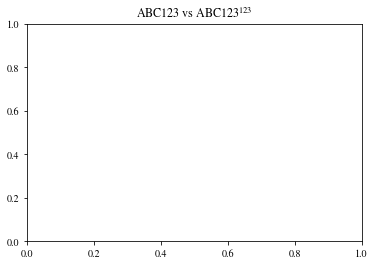

In [1]:
import pandas as pd
import numpy as np
import sys
import copy

import matplotlib.pyplot as plt
%matplotlib inline
# To change the default font like latex font
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
import matplotlib as mpl

import itertools
import scipy.stats as stats

In [2]:
def countCommas(s):
    try:
        return s.count(',')
    except:
        return np.nan

# Content

- [Data Import](#Data-Import)
- [Define functions and important variables](#Define-functions-and-important-variables)
- [Start Data Analysis](#Start-Data-Analysis)


# Data Import

-[Return](#Content)

In [3]:
data_ABA= pd.read_csv('..\\ProcessedData\\data_ABA.csv')
data_BAB=pd.read_csv('..\\ProcessedData\\data_BAB.csv')

In [4]:
# Data with opportunity 
data_Oppor_B1 = pd.read_csv('..\\ProcessedData\\data_Oppor_B1.csv')
data_Oppor_allB = pd.read_csv('..\\ProcessedData\\data_Oppor_allB.csv')

In [5]:
# Data local only 
data_noOppor_AllA = pd.read_csv('..\\ProcessedData\\data_noOppor_AllA.csv')
data_noOppor_A2=pd.read_csv('..\\ProcessedData\\data_noOppor_A2.csv')

In [6]:
# Imported the counterfactual data
# outputFolder = "..\\..\\Model\\SimulatedResults\\SimOutput\\"
# filename = 'BAB_Replicate.csv'
# filename = 'BABp_0.48_b_22_g_8.csv' # to make sure the file can replicate the fit graphs

# To check the results for 17, whether it is the correct model used in the paper! NOOO!!It is not!!
outputFolder = "..\\..\\Model\\SimulatedResults\\17-IEL-Recap-With-2Modifications-Final-Simulations-GridSearch-JoinBehaviorsAdded\\"
filename = 'BABp_0.48_b_22_g_8.csv' 

CounterfactualData = pd.read_csv(outputFolder+filename)
CounterfactualData = CounterfactualData[(CounterfactualData['FC']==20) | (CounterfactualData['FC']==80)]

# Start Data Analysis

Sequence : [7, 6, 18, 17, 13, 8, 12, 7]

A1 = [7] (10 rounds)

B1 = [6,18,17]

A2 = [13]

B2 = [8]

-[Local Only Environment ](#Local-Only-Environment )

-[Local + Global Environment](#Local-+-Global-Environment)

-[For simulation (Local Only)](#For-simulation-(Local-Only))

-[For simulation (Local + Global)](#For-simulation-(Local-+-Global))

-[Welfare Counterfactual](#Welfare-Counterfactual)

-[Return](#Content)


# Define functions and important variables 

-[Return](#Content)


In [7]:
def bootstrap_ci(data, n_samples, stat):
    
    n = len(data)                                #get length of the data
    ix = np.random.randint(0, n, (n_samples, n)) #get an array of bootsrapped indices
    samples = data[ix]                           #create bootrapped samples
    
    distribution = stat(samples, axis=1)

    return (np.percentile(distribution,2.5),np.percentile(distribution,97.5))

In [8]:
def permutation_test_r(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    original_stat=np.mean(sample1)-np.mean(sample2)
    print("Original Statistic:",original_stat)
    combined=np.append(sample1,sample2)
    #print combined
    permutations=np.matrix(list(itertools.permutations(combined)))
    print(permutations)
    n_permut=len(permutations)
    print("Number of permutations:",len(permutations))
    distr=permutations[:,0:n1].mean(axis=1)-permutations[:,n1:n1+n2].mean(axis=1)
    count=(distr<=original_stat).sum()
    print("Count: ",count," out of ",n_permut)
    p_val=np.round(float(count)/float(n_permut),3)
    print("Probability: ",p_val)

In [9]:
def permutation_test(pop_a, pop_b):

    original_statistics = pop_a.mean() - pop_b.mean()
    print(original_statistics)

    print('# 2. use permutation test (non-parametric test)' )
    n1 = len(pop_a)
    n2 = len(pop_b)
    
    sim_num = 10000
    
    combined = np.append(pop_a, pop_b)
#     permutationss=np.matrix(list(permutations(combined)))
#     n_permut=len(permutationss)
    n = len(combined)
    idx = np.arange(n)
    sim_d = []
    for i in range(sim_num):
        np.random.shuffle(idx)
        d = np.mean(combined[idx][0:n1]) - np.mean(combined[idx][n1::])
    #     print(d)
        sim_d.append(d)
    # calculate the p-value for two-sided test:
    count = (np.abs(sim_d)>=np.abs(original_statistics)).sum()
    # calculate the one-sided test, first-second
#     count = (np.array(sim_d)>=original_statistics).sum()
#     print(count)
    p_val = np.round((count+1)/(sim_num+1), 3)
    print("p-value for two-sided test", p_val)
    
#     distr=np.array(np.ma.mean(permutationss[:,0:n1],1)-np.ma.mean(permutationss[:,n1:n1+n2],1))
# #     count=(distr<=original_statistics).sum()
#     count=(np.abs(distr)>=np.abs(original_statistics)).sum()
#     print("Permutation Count: ",count," out of ",n_permut)
#     p_val=np.round(float(count)/float(n_permut),3)
#     print("two-sided Probability: ",p_val)


In [10]:
def CreateMean_CI_byHypothese(data, var, treatment_var, treatment_list, totalR):
    all_data = data
    # Create a matrix for 3 outputs: mean, upper CI, lower CI
    # The size is #Rounds * #Treatments
    output = np.empty((3, totalR, len(treatment_list)))
    output[:]=np.nan
    
    for i,t in enumerate(treatment_list): # Fixed the treatment order
        for r in range(1,totalR+1):
            pop_a = all_data.loc[(all_data[treatment_var]==t) & (all_data['subsession.period']==r), var]

            if not pop_a.empty :
                output[0,r-1,i] = pop_a.mean()
                output[1,r-1,i],output[2,r-1,i] = bootstrap_ci(np.array(pop_a), 10000, np.mean)
            else : 
                pass
    return output

## Compare Local and Global

-[Start Data Analysis](#Start-Data-Analysis)

# Local Only Environment 

- [Contribution average time trend ](#Contribution-average-time-trend )

- [Local only (others)](#Local-only-(others))


-[Start Data Analysis](#Start-Data-Analysis)

### Contribution average time trend 

-[Local Only Environment](#Local-Only-Environment)


In [11]:
# Data local only 
data_noOppor = data_noOppor_AllA
data_noOppor['End_level'] = "High (30)"
data_noOppor.loc[data_noOppor['endowment']==10,'End_level'] = "Low (10)"
data_noOppor.loc[data_noOppor['endowment']==20,'End_level'] = "Homo (20)"
data_noOppor['tot_cont_share'] = data_noOppor['tot_contr'] / data_noOppor['endowment'] * 100
data_noOppor['T_endw_comp']= data_noOppor['Treatment'] + ', ' + data_noOppor['End_level']
data_noOppor

subsession.round_number  subsession.period  subsession.sg  \
0                           1                  1              1   
1                           1                  1              1   
2                           1                  1              1   
3                           1                  1              1   
4                           1                  1              1   
...                       ...                ...            ...   
3195                       20                 20              1   
3196                       20                 20              1   
3197                       20                 20              1   
3198                       20                 20              1   
3199                       20                 20              1   

      player.id_in_group  player.endowment  player.join_club  \
0                      1             300.0                 0   
1                      5             300.0                 0   
2                      2             300.0                 0   
3                      6             300.0                 0   
4                      3             100.0                 0   
...                  ...               ...               ...   
3195                   6             200.0                 0   
3196                   3             200.0                 0   
3197                   7             200.0                 0   
3198                   4             200.0                 0   
3199                   8             200.0                 0   

      player.local_community  player.id_in_local  player.contribution_local  \
0                          1                   0                       10.0   
1                          2                   0                       10.0   
2                          1                   1                       10.0   
3                          2                   1                        0.0   
4                          1                   2                        4.0   
...                      ...                 ...                        ...   
3195                       0                   1                       20.0   
3196                       3                   2                        0.0   
3197                       0                   2                        1.0   
3198                       3                   3                        7.0   
3199                       0                   3                        0.0   

      player.contribution_global  ...  endowment_nj  tot_contr  privateAcc  \
0                            0.0  ...         300.0       10.0        20.0   
1                            0.0  ...         300.0       10.0        20.0   
2                            0.0  ...         300.0       10.0        20.0   
3                            0.0  ...         300.0        0.0        30.0   
4                            0.0  ...         100.0        4.0         6.0   
...                          ...  ...           ...        ...         ...   
3195                         0.0  ...         200.0       20.0         0.0   
3196                         0.0  ...         200.0        0.0        20.0   
3197                         0.0  ...         200.0        1.0        19.0   
3198                         0.0  ...         200.0        7.0        13.0   
3199                         0.0  ...         200.0        0.0        20.0   

      player.payoff_globalagg  player.endowment_globalagg  Efficiency  \
0                       230.0                      1600.0    0.598958   
1                       230.0                      1600.0    0.598958   
2                       230.0                      1600.0    0.598958   
3                       230.0                      1600.0    0.598958   
4                       230.0                      1600.0    0.598958   
...                       ...                         ...         ...   
3195                    207.6      

In [12]:
# For objective function: 
## First 10 matchesavg: 
First10 = data_noOppor[data_noOppor['subsession.period']<=10]
print('First10', First10.groupby(['Treatment', 'FC'])['tot_cont_share'].mean().to_numpy())


First10 [46.25       45.59722222 38.46875    45.57291667]


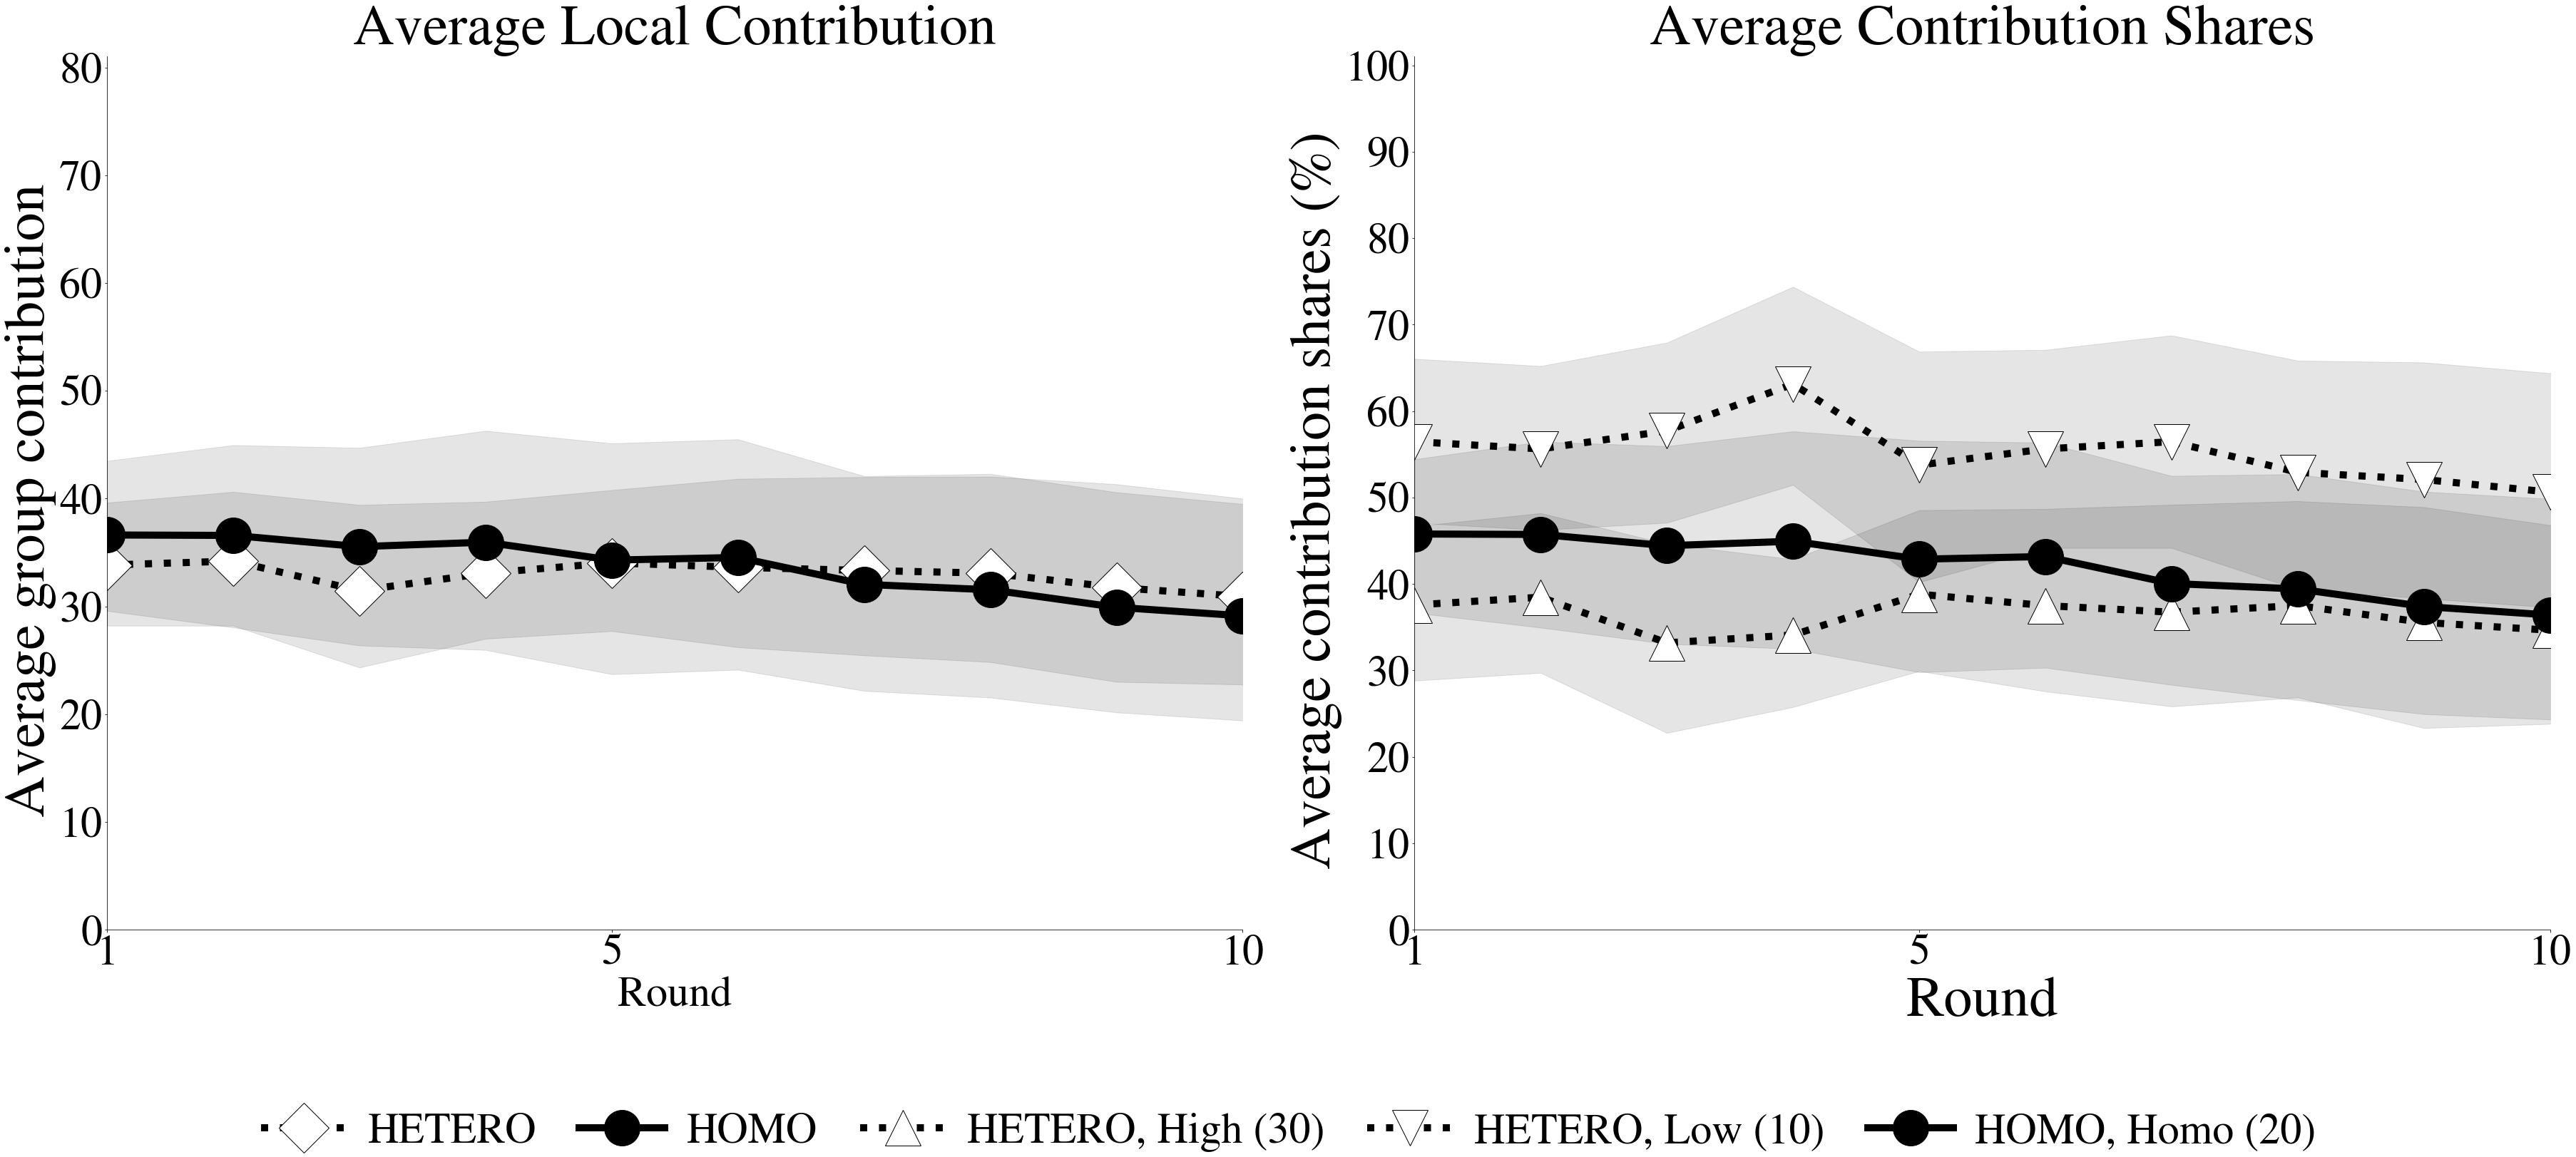

In [13]:
### This is to create the graph for all rounds

# Left graph for absolute value 
treatment_list = ['HETERO','HOMO']
treatment_var = 'Treatment'
var_of_interest =  'tot_contr'

LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()

output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list , 20)

df_local = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_local_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_local_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)



# right graph for absolute value 
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()
output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list_r , 20)

df_local_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_local_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_local_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 81)
custom_xtick = np.array([0,4,9,14,19])
custom_ytick = np.arange(0,81,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o',
                     }
    
custom_markercolor = ['black', 'black', ]
custom_markerfacecolor = ['white', 'black']
custom_linestyle = [':','-']

for j, yy in enumerate(treatment_list):
    axes[0].plot(df_local[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=50 )
    axes[0].fill_between(df_local_ci_u.index, df_local_ci_u[yy],df_local_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average group contribution ', fontsize=80)
axes[0].set_title('Average Local Contribution', fontsize=80)

# axes[0].spines['top'].set_visible(False)
# axes[0].spines['right'].set_visible(False)  
# axes[0].tick_params(axis='x', labelsize=40)
# axes[0].tick_params(axis='y', labelsize=40)



# Right figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': '^',
                    'HETERO, Low (10)': 'v',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_linestyle = [':',':','-']



for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_local_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=50 )
    axes[1].fill_between(df_local_ci_ur.index, df_local_ci_ur[yy],df_local_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[1].set_xlabel('Round', fontsize=80)
axes[1].set_ylabel('Average contribution shares (%) ', fontsize=80)
axes[1].set_title('Average Contribution Shares', fontsize=80)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=60)
    axes[i].tick_params(axis='y', labelsize=60)

# handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=60,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Only-Contribution.pdf', bbox_inches="tight" )  


# Local + Global Environment


-[% Join the club (both)](#%-Join-the-club-(both))


-[Contribution average time trend (both)](#Contribution-average-time-trend-(both))




-Return : [Start Data Analysis](#Start-Data-Analysis)

In [14]:
# Data local + global 
data_Oppor = data_Oppor_allB
data_Oppor['End_level'] = "Homo (20)" 
data_Oppor.loc[data_Oppor['endowment']<=10,'End_level'] = "Low (10)"
data_Oppor.loc[data_Oppor['endowment']>20,'End_level'] = "High (30)"
data_Oppor['tot_cont_share'] = data_Oppor['tot_contr'] / data_Oppor['endowment'] * 100
data_Oppor['T_endw_comp']= data_Oppor['Treatment'] + ', ' + data_Oppor['End_level']
data_Oppor['local_share'] = data_Oppor['player.contribution_local']/ data_Oppor['endowment'] * 100
data_Oppor['global_share'] = data_Oppor['player.contribution_global']/ data_Oppor['endowment'] * 100
data_Oppor['Join_share'] = data_Oppor['player.join_club']*100

data_Oppor

subsession.round_number  subsession.period  subsession.sg  \
0                           1                  1              1   
1                           1                  1              1   
2                           1                  1              1   
3                           1                  1              1   
4                           1                  1              1   
...                       ...                ...            ...   
7035                       10                 10              1   
7036                       10                 10              1   
7037                       10                 10              1   
7038                       10                 10              1   
7039                       10                 10              1   

      player.id_in_group  player.endowment  player.join_club  \
0                      1             280.0                 1   
1                      5             280.0                 1   
2                      2             300.0                 0   
3                      6             280.0                 1   
4                      3              80.0                 1   
...                  ...               ...               ...   
7035                   6             180.0                 1   
7036                   3             180.0                 1   
7037                   7             180.0                 1   
7038                   4             180.0                 1   
7039                   8             180.0                 1   

      player.local_community  player.id_in_local  player.contribution_local  \
0                          1                   0                        8.0   
1                          2                   0                        5.0   
2                          1                   1                       10.0   
3                          2                   1                        6.0   
4                          1                   2                        3.0   
...                      ...                 ...                        ...   
7035                       0                   1                        0.0   
7036                       3                   2                        0.0   
7037                       0                   2                        0.0   
7038                       3                   3                        2.0   
7039                       0                   3                        0.0   

      player.contribution_global  ...  ClubSize  SocialBenefitMax  \
0                            8.0  ...         7            5592.0   
1                            5.0  ...         7            5592.0   
2                            0.0  ...         7            5592.0   
3                            6.0  ...         7            5592.0   
4                            5.0  ...         7            5592.0   
...                          ...  ...       ...               ...   
7035                         0.0  ...         8            6912.0   
7036                         0.0  ...         8            6912.0   
7037                         3.0  ...         8            6912.0   
7038                         9.0  ...         8            6912.0   
7039                        18.0  ...         8            6912.0   

      Efficiency2  Sequence  End_level  tot_cont_share        T_endw_comp  \
0        0.568670        B1  High (30)       57.142857  HETERO, High (30)   
1        0.568670        B1  High (30)       35.714286  HETERO, High (30)   
2        0.568670        B1  High (30)       33.333333  HETERO, High (30)   
3        0.568670        B1  High (30)       42.857143  HETERO, High (30)   
4        0.568670        B1   Low (10)      100.000000   HETERO, Low (10)   
...           ...       ...        ...             ...                ...   
7035     0.501447    B2_bab  Homo (20)        0.000000    HOMO, Homo (20)   
7036     0.501447    B2_bab  Homo (20)

In [15]:
# For objective function: 
## First 10 matchesavg: 
First10 = data_Oppor[data_Oppor['subsession.period']<=10]
print('First10', First10.groupby(['Treatment', 'FC'])['Join_share', 'local_share', 'global_share'].mean().to_numpy())

First5_10 = data_Oppor[(data_Oppor['subsession.period']<=10)&(data_Oppor['subsession.period']>=6)]
print('First5_10', First5_10.groupby(['Treatment', 'FC'])['Join_share', 'local_share', 'global_share'].mean().to_numpy())

First10 [[95.08928571  9.73320578 38.15529337]
 [35.80357143 30.90665584 17.25243506]
 [97.32142857  9.29017857 34.98511905]
 [64.82142857 14.35863095 34.44196429]]
First5_10 [[95.35714286  8.88052721 38.20153061]
 [25.35714286 34.64177489 11.59090909]
 [97.85714286  8.43849206 33.42261905]
 [55.17857143 16.70535714 27.8422619 ]]


C:\Users\xinxi\AppData\Local\Temp/ipykernel_3224/3888877126.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print('First10', First10.groupby(['Treatment', 'FC'])['Join_share', 'local_share', 'global_share'].mean().to_numpy())
C:\Users\xinxi\AppData\Local\Temp/ipykernel_3224/3888877126.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print('First5_10', First5_10.groupby(['Treatment', 'FC'])['Join_share', 'local_share', 'global_share'].mean().to_numpy())


### % Join the club (both)

Return: 
 [Local + Global Environment](#Local-+-Global-Environment)


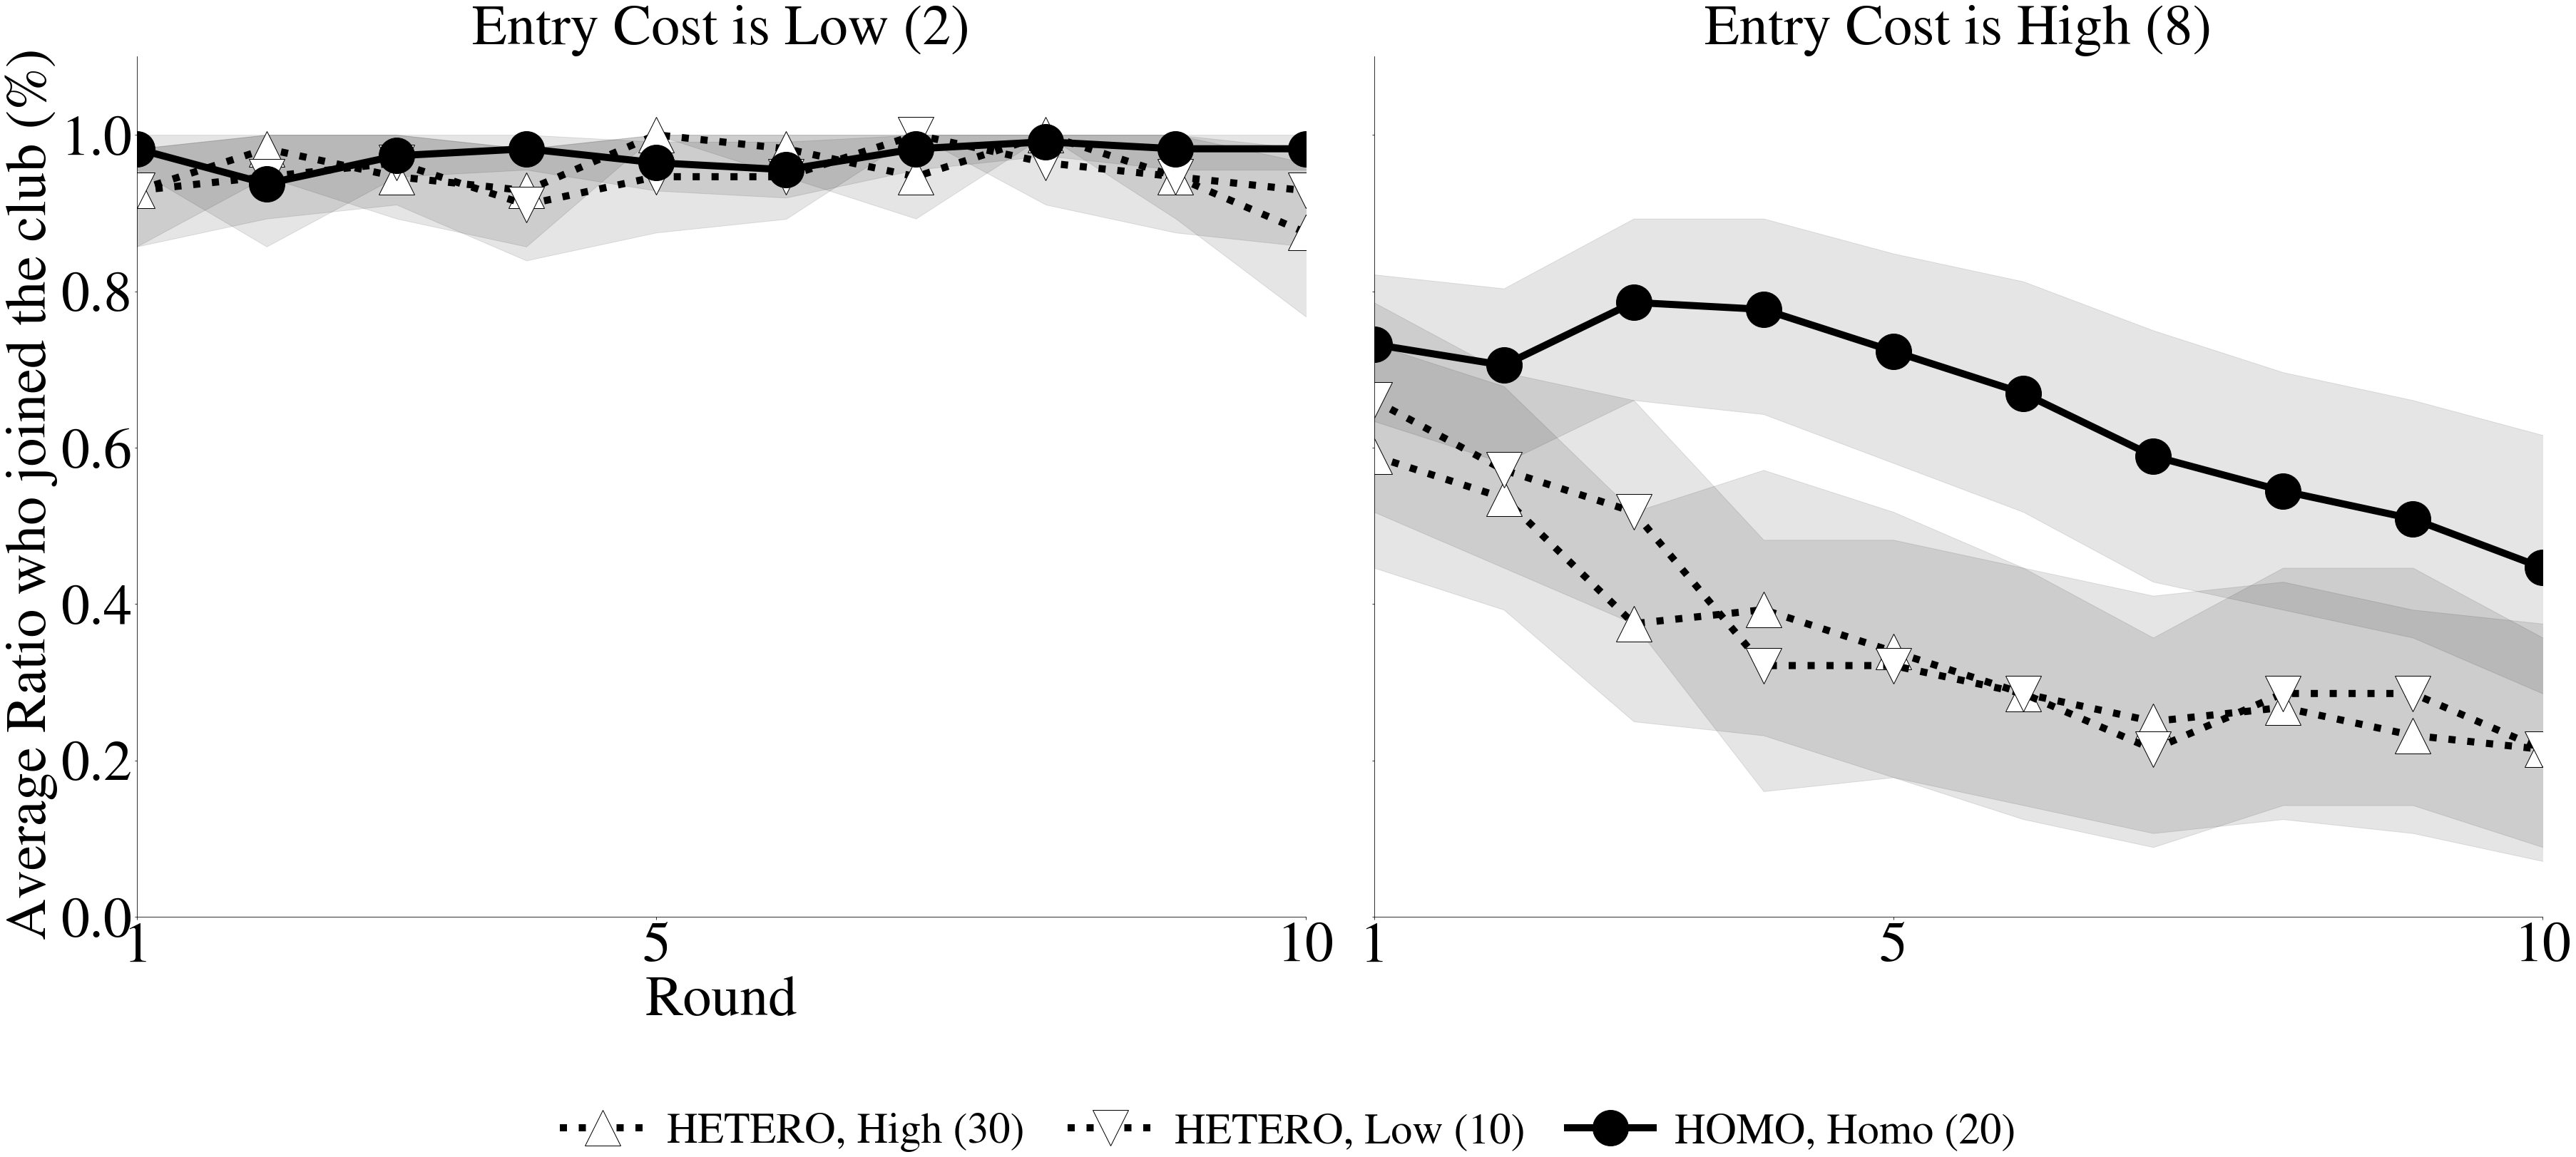

In [16]:
### This is to create the graph for all rounds
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.join_club'
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

df_join = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_join_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_join_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_join_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_join_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_join_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 1.1)
custom_ytick = np.arange(0,1.1,step=0.2)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': '^',
                    'HETERO, Low (10)': 'v',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df_join[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=50 )
    axes[0].fill_between(df_join_ci_u.index, df_join_ci_u[yy],df_join_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=80)
axes[0].set_ylabel('Average Ratio who joined the club (%) ', fontsize=80)
axes[0].set_title('Entry Cost is Low (2)', fontsize=80)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_join_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=50 )
    axes[1].fill_between(df_join_ci_ur.index, df_join_ci_ur[yy],df_join_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

axes[1].set_title('Entry Cost is High (8)', fontsize=80)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=80)
    axes[i].tick_params(axis='y', labelsize=80)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=60,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Join.pdf', bbox_inches="tight" )  


### Contribution average time trend (both)

Return: 
 [Local + Global Environment](#Local-+-Global-Environment)


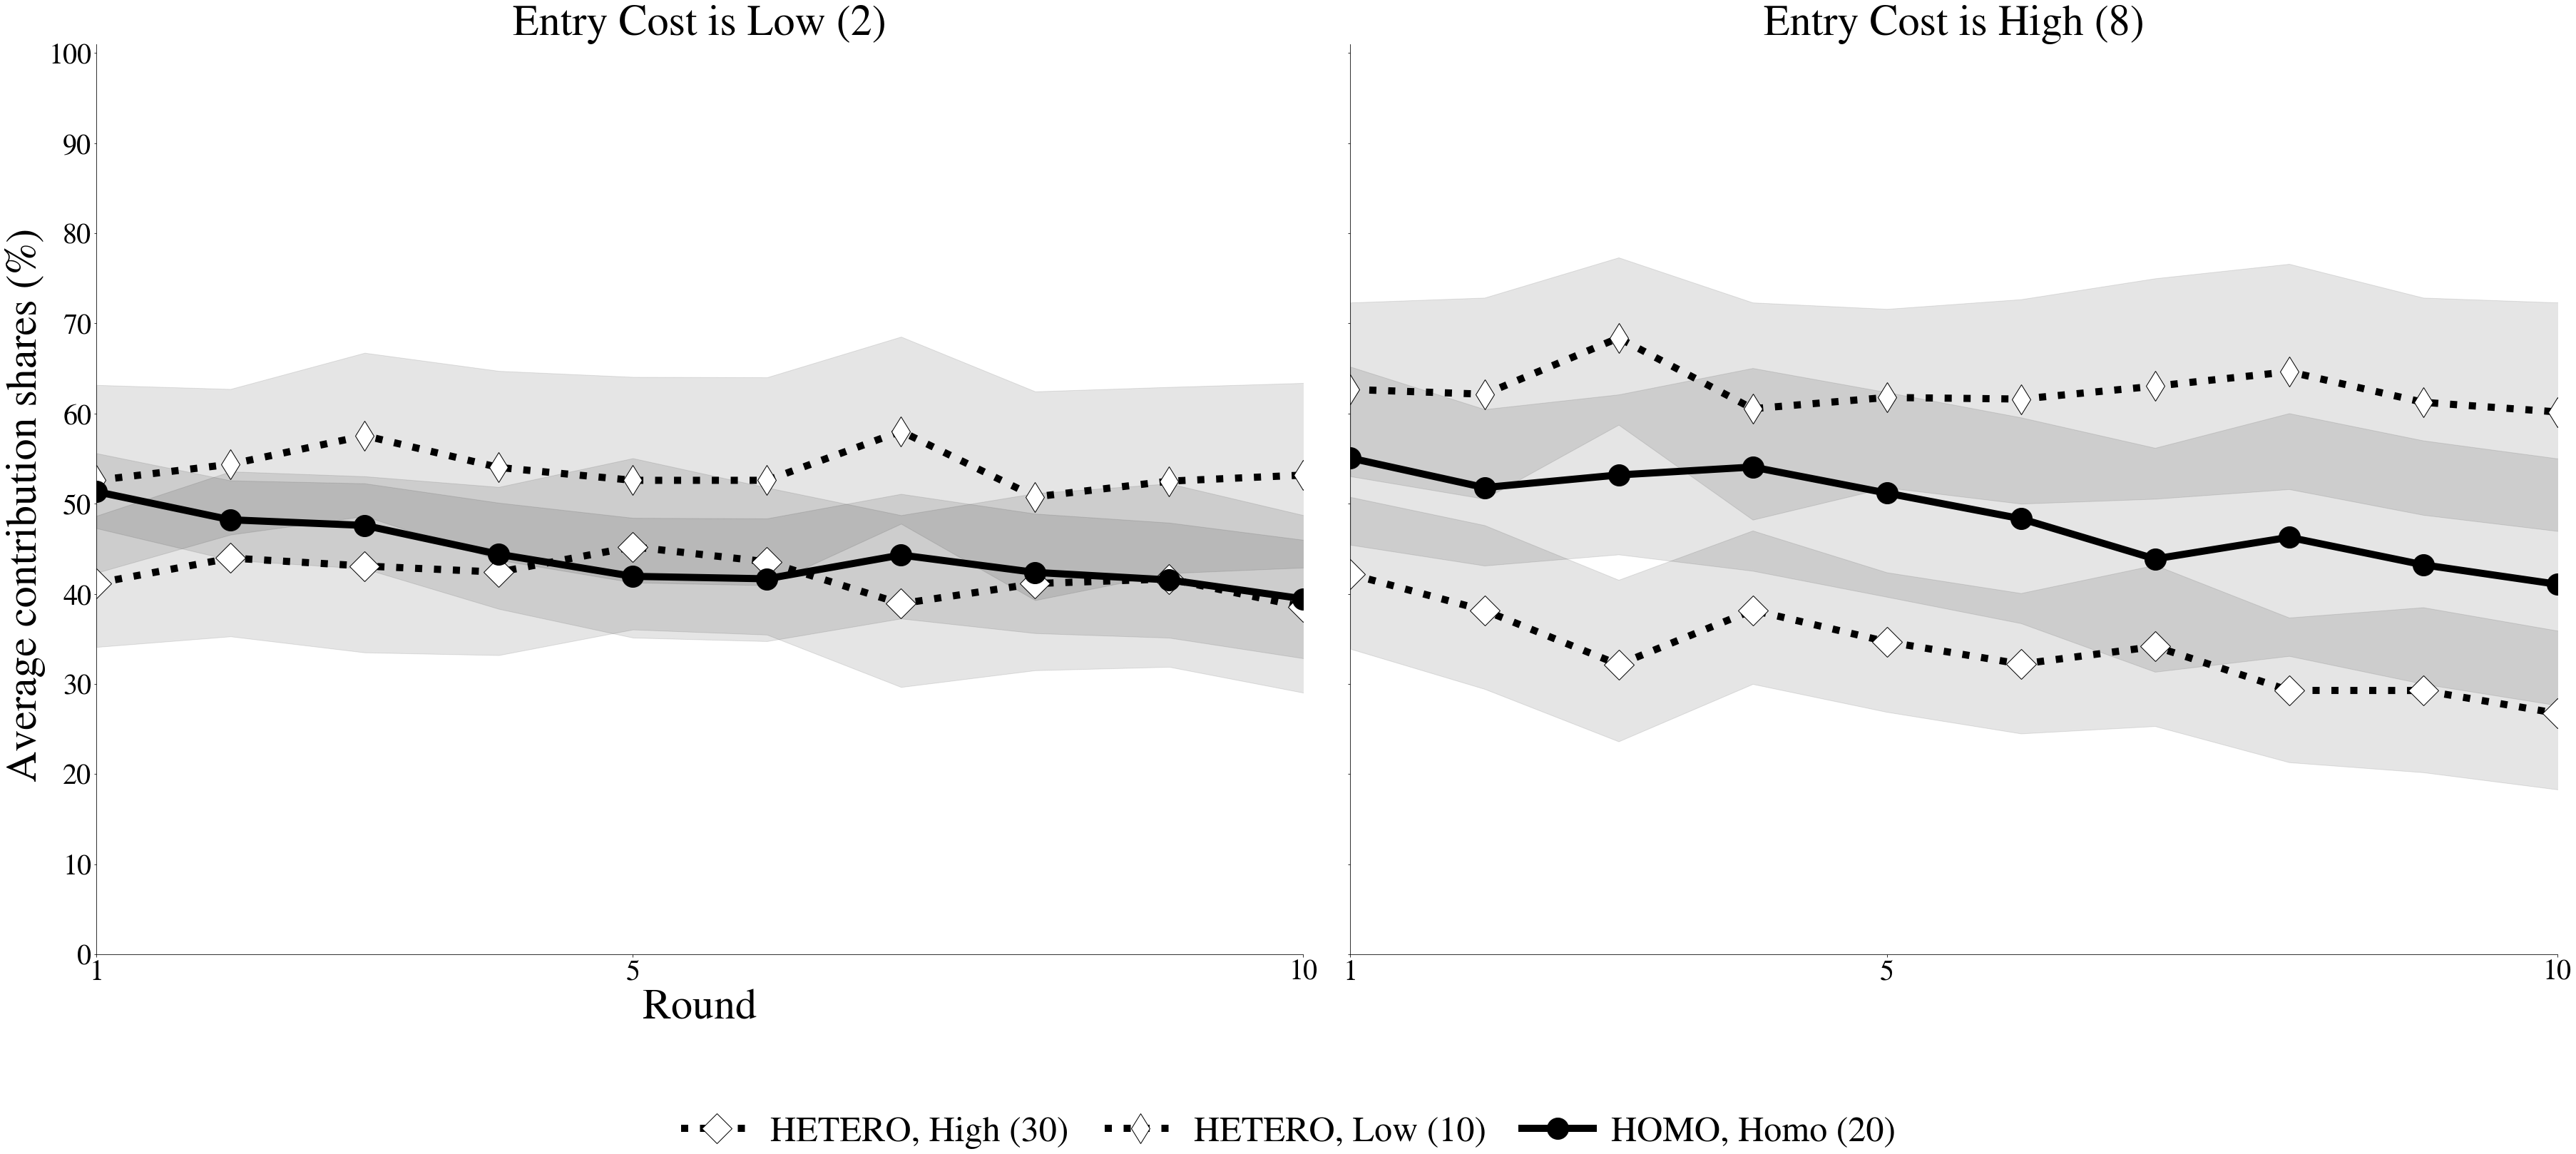

In [17]:
### This is to create the graph for all rounds
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

df_contrshare = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_contrshare_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_contrshare_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_contrshare_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_contrshare_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_contrshare_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df_contrshare[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_contrshare_ci_u.index, df_contrshare_ci_u[yy],df_contrshare_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average contribution shares (%) ', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_contrshare_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_contrshare_ci_ur.index, df_contrshare_ci_ur[yy],df_contrshare_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
# fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution.pdf_contrshare', bbox_inches="tight" )  


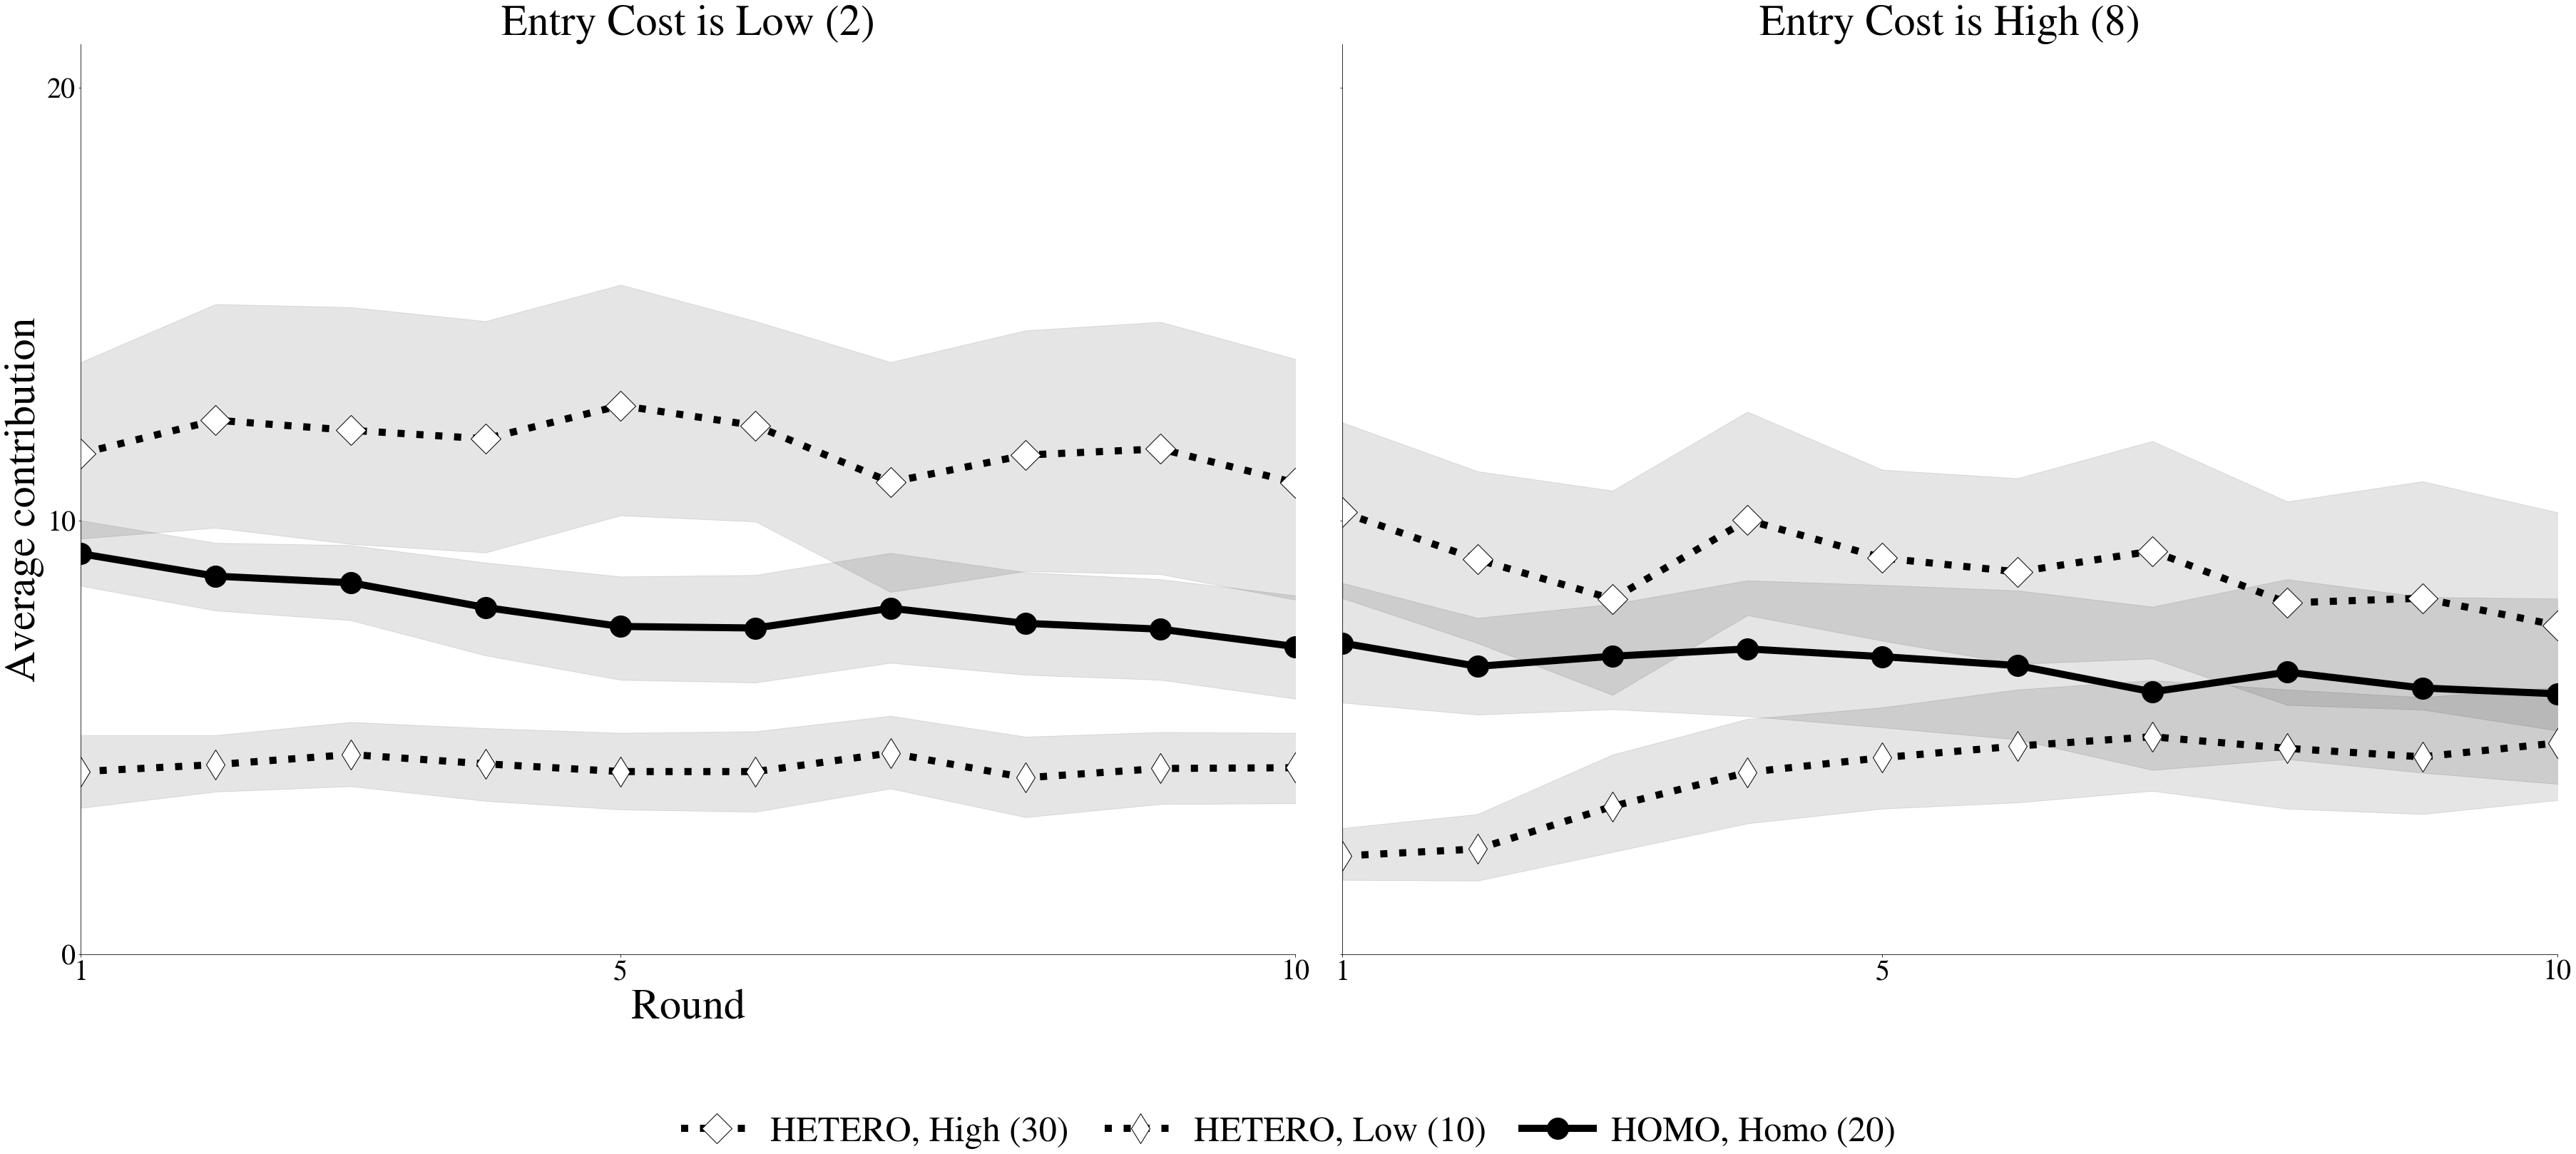

In [18]:
### Contribution Level
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'tot_contr'
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

df_contrlev = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_contrlev_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_contrlev_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_contrlev_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_contrlev_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_contrlev_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0,9)
custom_ylim = (0, 21)
custom_ytick = np.arange(0,21,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df_contrlev[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_contrlev_ci_u.index, df_contrlev_ci_u[yy],df_contrlev_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average contribution', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_contrlev_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_contrlev_ci_ur.index, df_contrlev_ci_ur[yy],df_contrlev_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
# fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution2.pdf_contrlev', bbox_inches="tight" )  


# For simulation (Local Only)

-Return : [Start Data Analysis](#Start-Data-Analysis)


In [19]:
# Prepare to add the simulated data on top of the experimental data
# data_noOppor_sim = CounterfactualData_cut[CounterfactualData_cut['Sequence']=='A2_bab']
data_noOppor_sim = CounterfactualData[CounterfactualData['Sequence']=='A2_bab']

data_noOppor_sim['tot_contr'] = data_noOppor_sim['player.contribution_local']
data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['player.contribution_local'] / data_noOppor_sim['endow_org']
data_noOppor_sim['End_level'] = "High (30)"
data_noOppor_sim.loc[data_noOppor_sim['endow_org']==10,'End_level'] = "Low (10)"
data_noOppor_sim.loc[data_noOppor_sim['endow_org']==20,'End_level'] = "Homo (20)"
data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['tot_contr'] / data_noOppor_sim['endow_org'] * 100
data_noOppor_sim['T_endw_comp']= data_noOppor_sim['Treatment'] + ', ' + data_noOppor_sim['End_level']


# Left graph for absolute value 
treatment_list = ['HETERO','HOMO']
treatment_var = 'Treatment'
var_of_interest =  'tot_contr'

LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()

output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)


LocalOnly = data_noOppor_sim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()

output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list , 20)

dfSim = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_lSim = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_uSim = pd.DataFrame(output[2,:,:], columns = treatment_list)


# right graph for absolute value 
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()
output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list_r , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_noOppor_sim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()
output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list_r , 20)

df_rSim = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lrSim = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_urSim = pd.DataFrame(output[2,:,:], columns = treatment_list_r)


C:\Users\xinxi\AppData\Local\Temp/ipykernel_3224/2589311535.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noOppor_sim['tot_contr'] = data_noOppor_sim['player.contribution_local']
C:\Users\xinxi\AppData\Local\Temp/ipykernel_3224/2589311535.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['player.contribution_local'] / data_noOppor_sim['endow_org']
C:\Users\xinxi\AppData\Local\Temp/ipykernel_3224/2589311535.py:7: SettingWithCopyWarning: 
A va

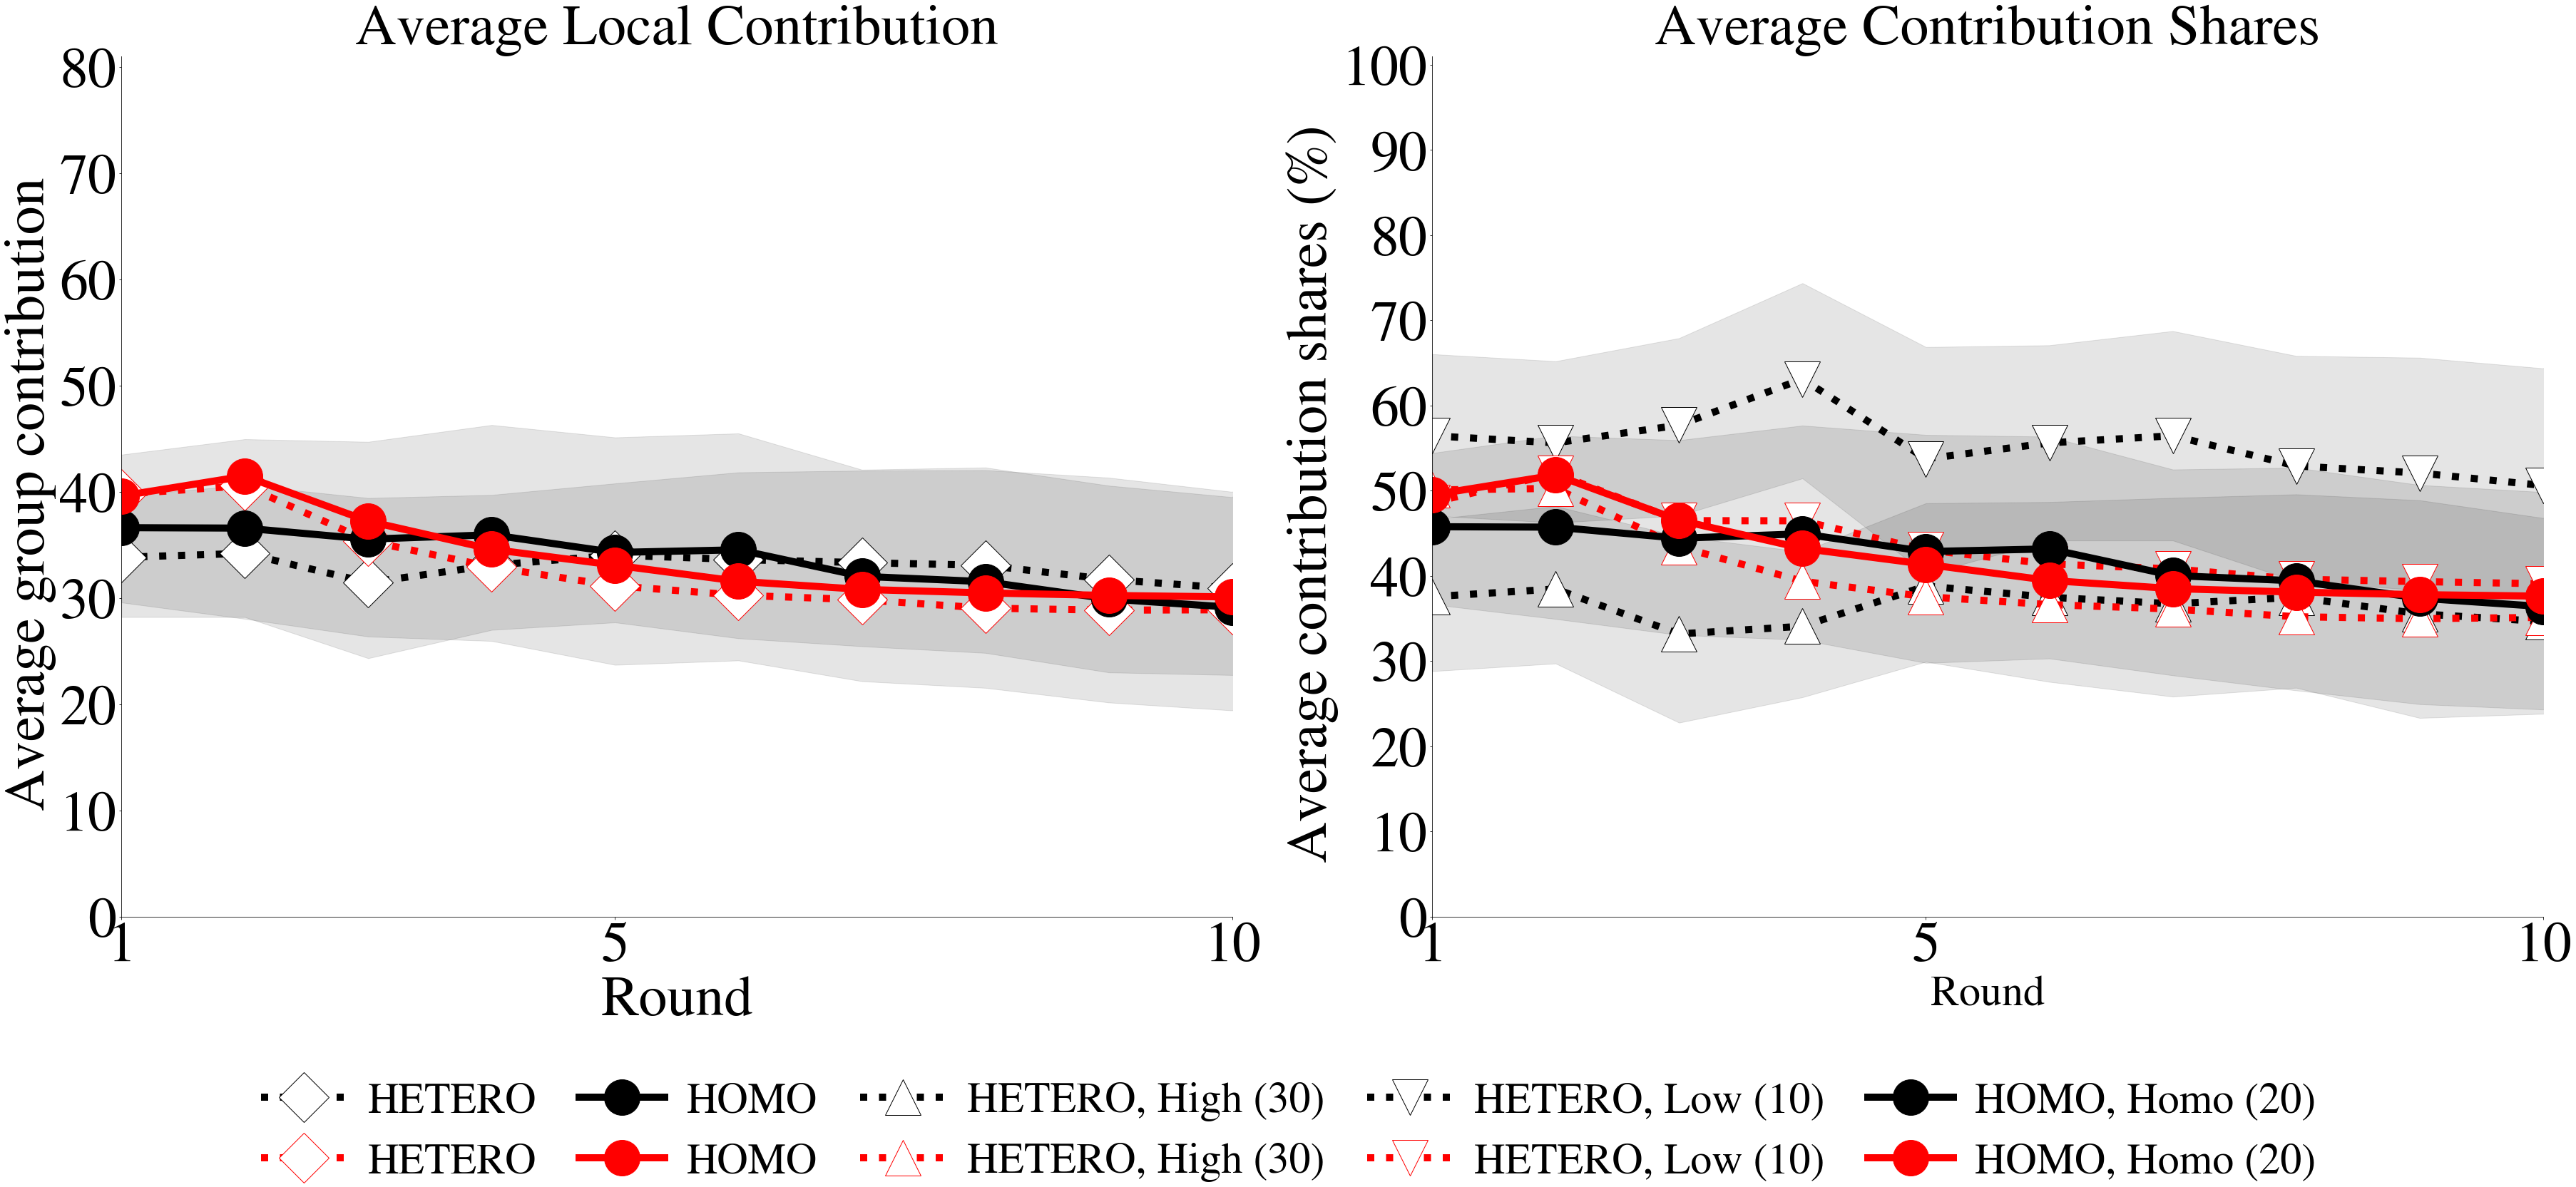

In [20]:
### Compare with Simulation results

pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 81)
custom_xtick = np.array([0,4,9,14,19])
custom_ytick = np.arange(0,81,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o',
                     }
    
custom_markercolor = ['black', 'black', ]
custom_markerfacecolor = ['white', 'black']
custom_markerfacecolorR = ['white', 'red']
custom_linestyle = [':','-']

for j, yy in enumerate(treatment_list):
    axes[0].plot(df_local[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=50 )
    axes[0].fill_between(df_local_ci_u.index, df_local_ci_u[yy],df_local_ci_l[yy], alpha=0.1, color=custom_markercolor[j])
    axes[0].plot(dfSim[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolorR[j],
                         linewidth=10,  markersize=50 )
#     axes[0].fill_between(df_ci_uSim.index, df_ci_uSim[yy],df_ci_lSim[yy], alpha=0.1, color='red')

    
axes[0].set_xlabel('Round', fontsize=80)
axes[0].set_ylabel('Average group contribution ', fontsize=80)
axes[0].set_title('Average Local Contribution', fontsize=80)

# axes[0].spines['top'].set_visible(False)
# axes[0].spines['right'].set_visible(False)  
# axes[0].tick_params(axis='x', labelsize=40)
# axes[0].tick_params(axis='y', labelsize=40)



# Right figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': '^',
                    'HETERO, Low (10)': 'v',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_markerfacecolor_s = ['white', 'white','red']
custom_linestyle = [':',':','-']



for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_local_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=50 )
    axes[1].fill_between(df_local_ci_ur.index, df_local_ci_ur[yy],df_local_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])
    axes[1].plot(df_rSim[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=50 )
#     axes[1].fill_between(df_ci_urSim.index, df_ci_urSim[yy],df_ci_lrSim[yy], alpha=0.1, color='red')
    
axes[1].set_xlabel('Round', fontsize=60)
axes[1].set_ylabel('Average contribution shares (%) ', fontsize=80)
axes[1].set_title('Average Contribution Shares', fontsize=80)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=80)
    axes[i].tick_params(axis='y', labelsize=80)

handles, labels = axes[1].get_legend_handles_labels() 

fig.legend(bbox_to_anchor=(.5,-.1), loc="center" , ncol=5, fontsize=60,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
# fig.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simulation-Local-Only-Contribution-WithSim.pdf', bbox_inches="tight" )  


# For simulation (Local + Global)

-Return : [Start Data Analysis](#Start-Data-Analysis)

In [21]:
# CounterfactualData_cut
# For the simulated results
# Data local + global 
# data_OpporSim = CounterfactualData_cut[CounterfactualData_cut['Sequence']=='B1_bab']
data_OpporSim = CounterfactualData[CounterfactualData['Sequence']=='B1_bab']

data_OpporSim['End_level'] = "Homo (20)" 
data_OpporSim['tot_contr'] = data_OpporSim['player.contribution_local'] + np.nan_to_num(data_OpporSim['player.contribution_global'])
data_OpporSim['endowment'] = data_OpporSim['endow_org'] - 1*(1-np.isnan(data_OpporSim['player.contribution_global']))*data_OpporSim['FC']/10
data_OpporSim.loc[data_OpporSim['endow_org']<=10,'End_level'] = "Low (10)"
data_OpporSim.loc[data_OpporSim['endow_org']>20,'End_level'] = "High (30)"


data_OpporSim['tot_cont_share'] = data_OpporSim['tot_contr'] / data_OpporSim['endowment'] * 100
data_OpporSim['T_endw_comp']= data_OpporSim['Treatment'] + ', ' + data_OpporSim['End_level']
data_OpporSim['local_share'] = data_OpporSim['player.contribution_local']/ data_OpporSim['endowment'] * 100
data_OpporSim['global_share'] = data_OpporSim['player.contribution_global']/ data_OpporSim['endowment'] * 100

data_OpporSim['player.join_club'] = 1-np.isnan(data_OpporSim['player.contribution_global'])
# data_OpporSim.loc[(data_OpporSim['endowment']==10) & (data_OpporSim['player.join_club']==1) & (data_OpporSim['FC']==100) ,'End_level'] = "Homo (20)"
# data_OpporSim.loc[(data_OpporSim['endowment']==20) & (data_OpporSim['player.join_club']==1) & (data_OpporSim['FC']==100) ,'End_level'] = "High (30)"


C:\Users\xinxi\AppData\Local\Temp/ipykernel_3224/3024599332.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_OpporSim['End_level'] = "Homo (20)"
C:\Users\xinxi\AppData\Local\Temp/ipykernel_3224/3024599332.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_OpporSim['tot_contr'] = data_OpporSim['player.contribution_local'] + np.nan_to_num(data_OpporSim['player.contribution_global'])
C:\Users\xinxi\AppData\Local\Temp/ipykernel_3224/3024599332.py:9: SettingWithCopyWarning: 
A value is trying to be

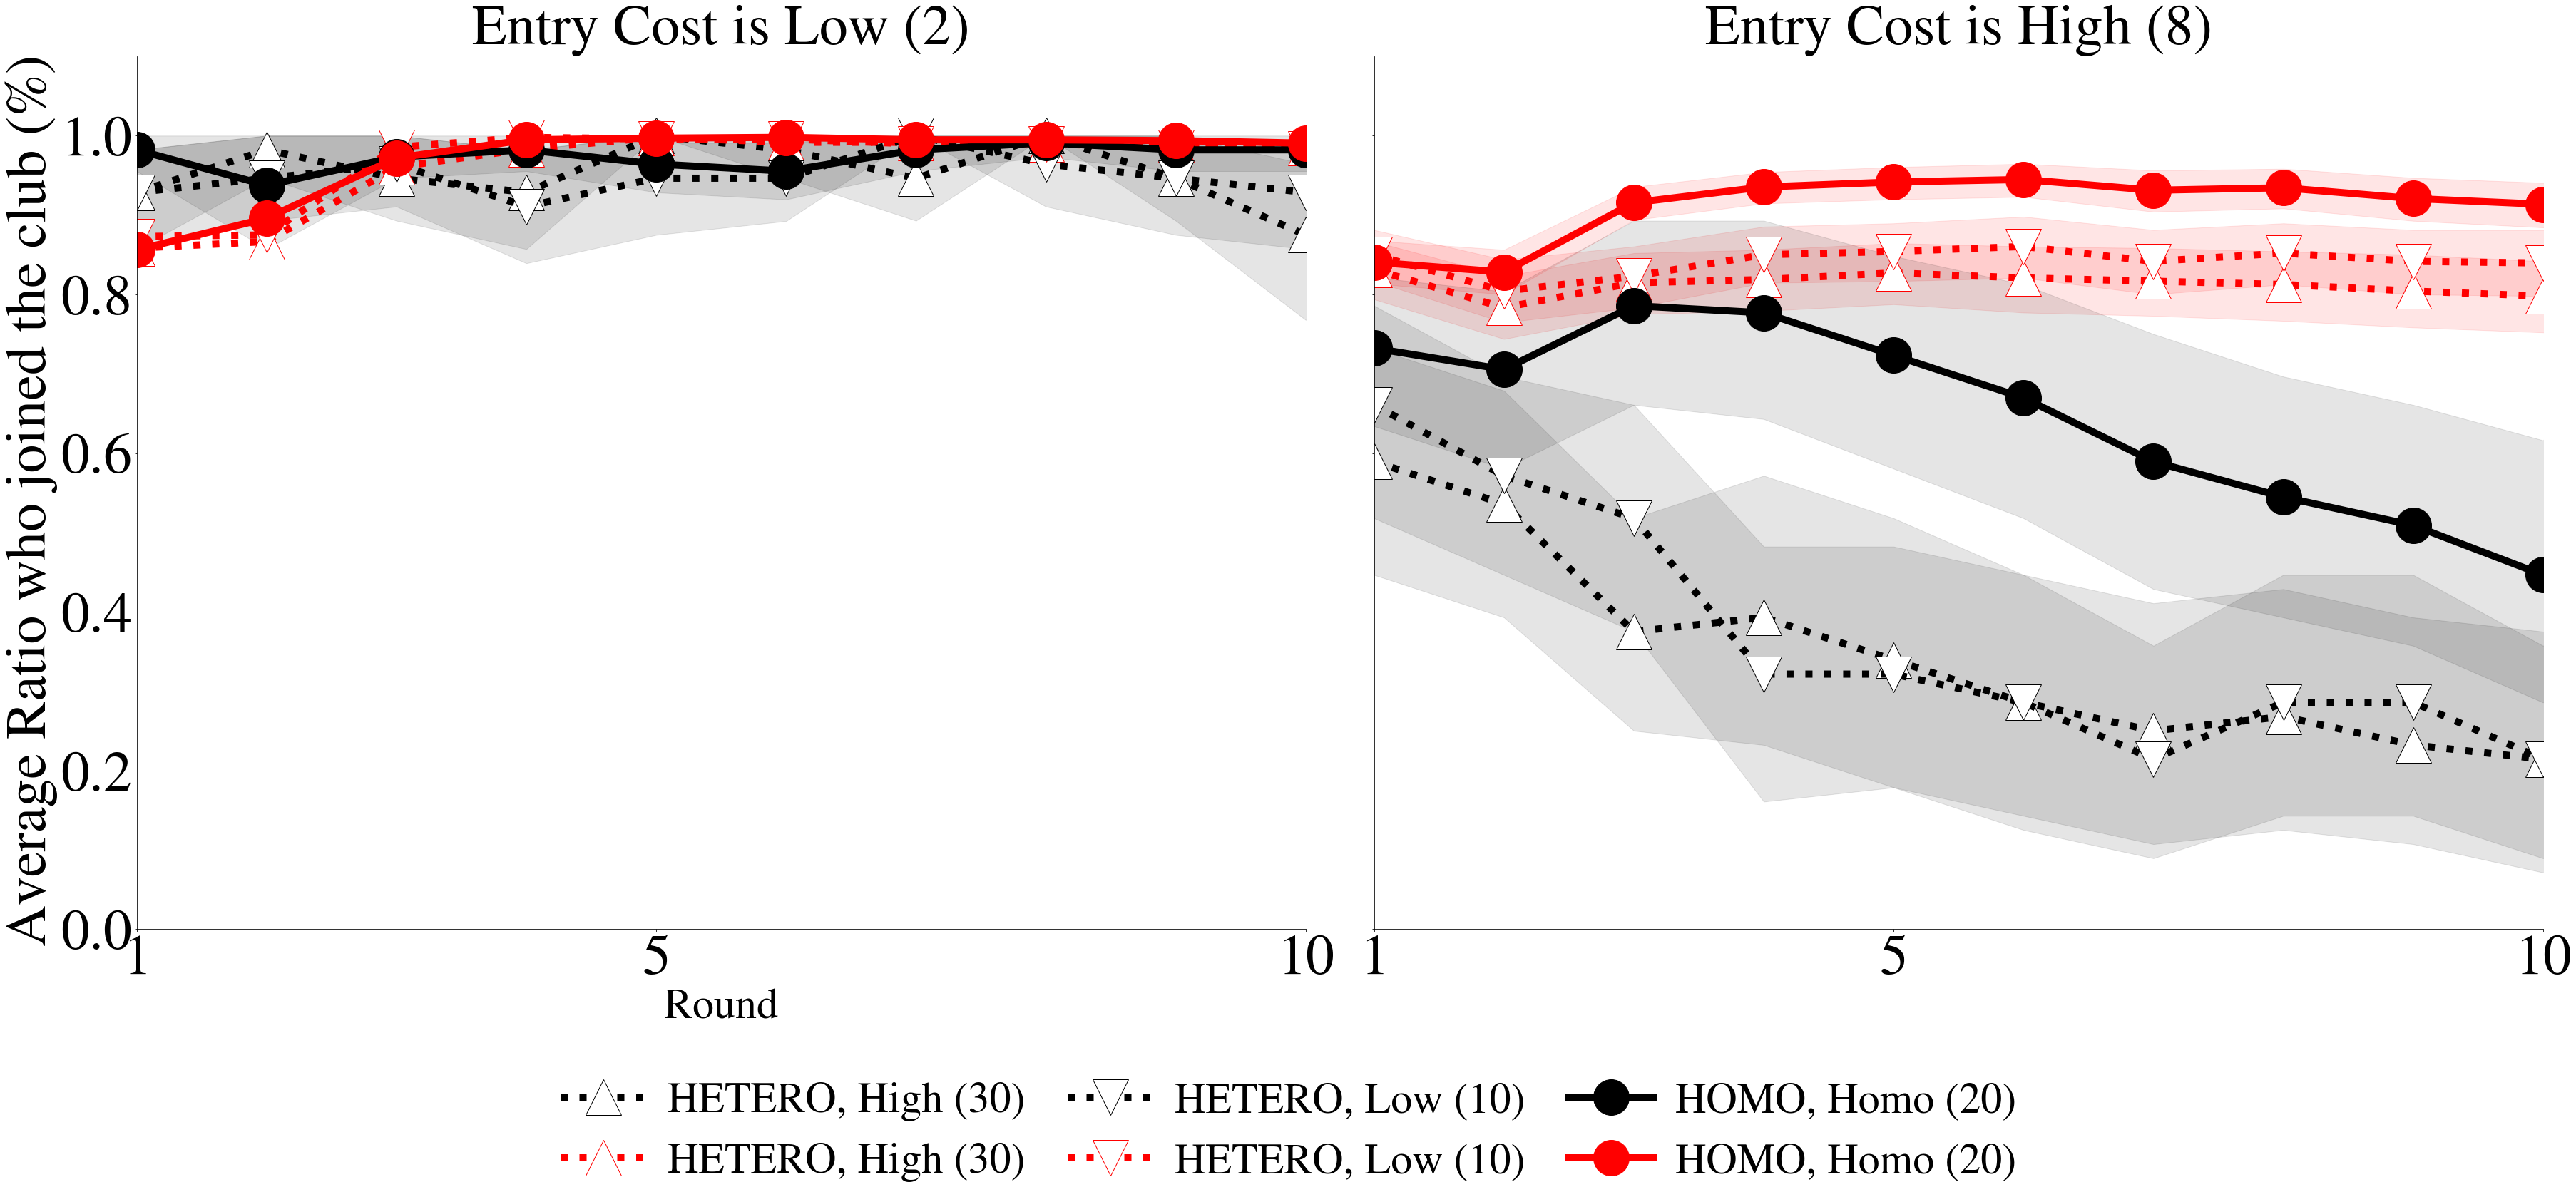

In [22]:
 # Join Behavior
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.join_club'
LocalOnly = data_OpporSim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

dfSimj = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lSimj = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_uSimj = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_rSimj = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lrSimj = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_urSimj = pd.DataFrame(output[2,:,:], columns = treatment_list_r)
    
### This is to create the graph for all rounds
pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 1.1)
custom_ytick = np.arange(0,1.1,step=0.2)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': '^',
                    'HETERO, Low (10)': 'v',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_markerfacecolor_s = ['white', 'white','red']
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df_join[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=50 )
    axes[0].fill_between(df_join_ci_u.index, df_join_ci_u[yy],df_join_ci_l[yy], alpha=0.1, color=custom_markercolor[j])
    axes[0].plot(dfSimj[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=50 )
#     axes[0].fill_between(df_ci_uSimj.index, df_ci_uSimj[yy],df_ci_lSimj[yy], alpha=0.1, color='red')

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average Ratio who joined the club (%) ', fontsize=80)
axes[0].set_title('Entry Cost is Low (2)', fontsize=80)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_join_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=50 )
    axes[1].fill_between(df_join_ci_ur.index, df_join_ci_ur[yy],df_join_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])
    axes[1].plot(df_rSimj[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=50 )
    axes[1].fill_between(df_ci_urSimj.index, df_ci_urSimj[yy],df_ci_lrSimj[yy], alpha=0.1, color='red')

axes[1].set_title('Entry Cost is High (8)', fontsize=80)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=80)
    axes[i].tick_params(axis='y', labelsize=80)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=3 , fontsize=60,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
# fig.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simjulation-Local-Global-Join-add-simulation.pdf', bbox_inches="tight" )  
    

In [23]:
# ### Contribution Share
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']

# # For the simulated data

# treatment_var = 'T_endw_comp'
# var_of_interest =  'tot_cont_share'
# LocalOnly = data_OpporSim.groupby([ 
#                       treatment_var,
#     'player.local_community',  'session_num',
#                       'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# # Left graph for FC=2
# output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

# dfSim = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
# df_ci_lSim = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
# df_ci_uSim = pd.DataFrame(output[2,:,:], columns = treatment_list_r)


# # right graph for absolute value 

# output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

# df_rSim = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
# df_ci_lrSim = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
# df_ci_urSim = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




# pd.set_option('plotting.backend', 'matplotlib')



# fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
#                          constrained_layout=True, figsize=(50, 20))
# fig.set_constrained_layout_pads( w_pad=1 / 100)

# # Left figure
# # Defining custom 'xlim' and 'ylim' values.
# custom_xlim = (0, 9)
# custom_ylim = (0, 101)
# custom_ytick = np.arange(0,101,step=10)
# custom_xticklabel = [1,5,10,15,20]

# plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
#      yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# # custom_marker = ['o','o', 'D', 'D', '*', '*']
# treatment_marker = {'HETERO, High (30)': 'D',
#                     'HETERO, Low (10)': 'd',
#                     'HOMO, Homo (20)': 'o'
#                      }
    
# custom_markercolor = ['black','black', 'black', ]
# custom_markerfacecolor = ['white', 'white','black']
# custom_markerfacecolor_s = ['white', 'white','red']
# custom_linestyle = [':',':','-']


# for j, yy in enumerate(treatment_list_r):
#     axes[0].plot(df_contrshare[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
#                          ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
#                          linewidth=10,  markersize=30 )
#     axes[0].fill_between(df_contrshare_ci_u.index, df_contrshare_ci_u[yy],df_contrshare_ci_l[yy], alpha=0.1, color=custom_markercolor[j])
#     axes[0].plot(dfSim[yy], label=yy, marker=treatment_marker[yy], c='red', 
#                          ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
#                          linewidth=10,  markersize=30 )
# #     axes[0].fill_between(df_ci_uSim.index, df_ci_uSim[yy],df_ci_lSim[yy], alpha=0.1, color='red')

    
# axes[0].set_xlabel('Round', fontsize=60)
# axes[0].set_ylabel('Average contribution shares (%) ', fontsize=60)
# axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# # Right figure
# # Defining custom 'xlim' and 'ylim' values.
# plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
#      yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


# for j, yy in enumerate(treatment_list_r):
#     axes[1].plot(df_contrshare_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
#                          ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
#                          linewidth=10,  markersize=30 )
#     axes[1].fill_between(df_contrshare_ci_ur.index, df_contrshare_ci_ur[yy],df_contrshare_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])
#     axes[1].plot(df_rSim[yy], label=yy, marker=treatment_marker[yy], c='red', 
#                          ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
#                          linewidth=10,  markersize=30 )
# #     axes[1].fill_between(df_ci_urSim.index, df_ci_urSim[yy],df_ci_lrSim[yy], alpha=0.1, color='red')

# axes[1].set_title('Entry Cost is High (8)', fontsize=60)

# for i in range(2):
#     axes[i].spines['top'].set_visible(False)
#     axes[i].spines['right'].set_visible(False)  
#     axes[i].tick_params(axis='x', labelsize=40)
#     axes[i].tick_params(axis='y', labelsize=40)

# handles, labels = axes[0].get_legend_handles_labels() 

# fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
#                borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
# fig.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simulation-Local-Global-Contribution-add-simulation.pdf', bbox_inches="tight" )  


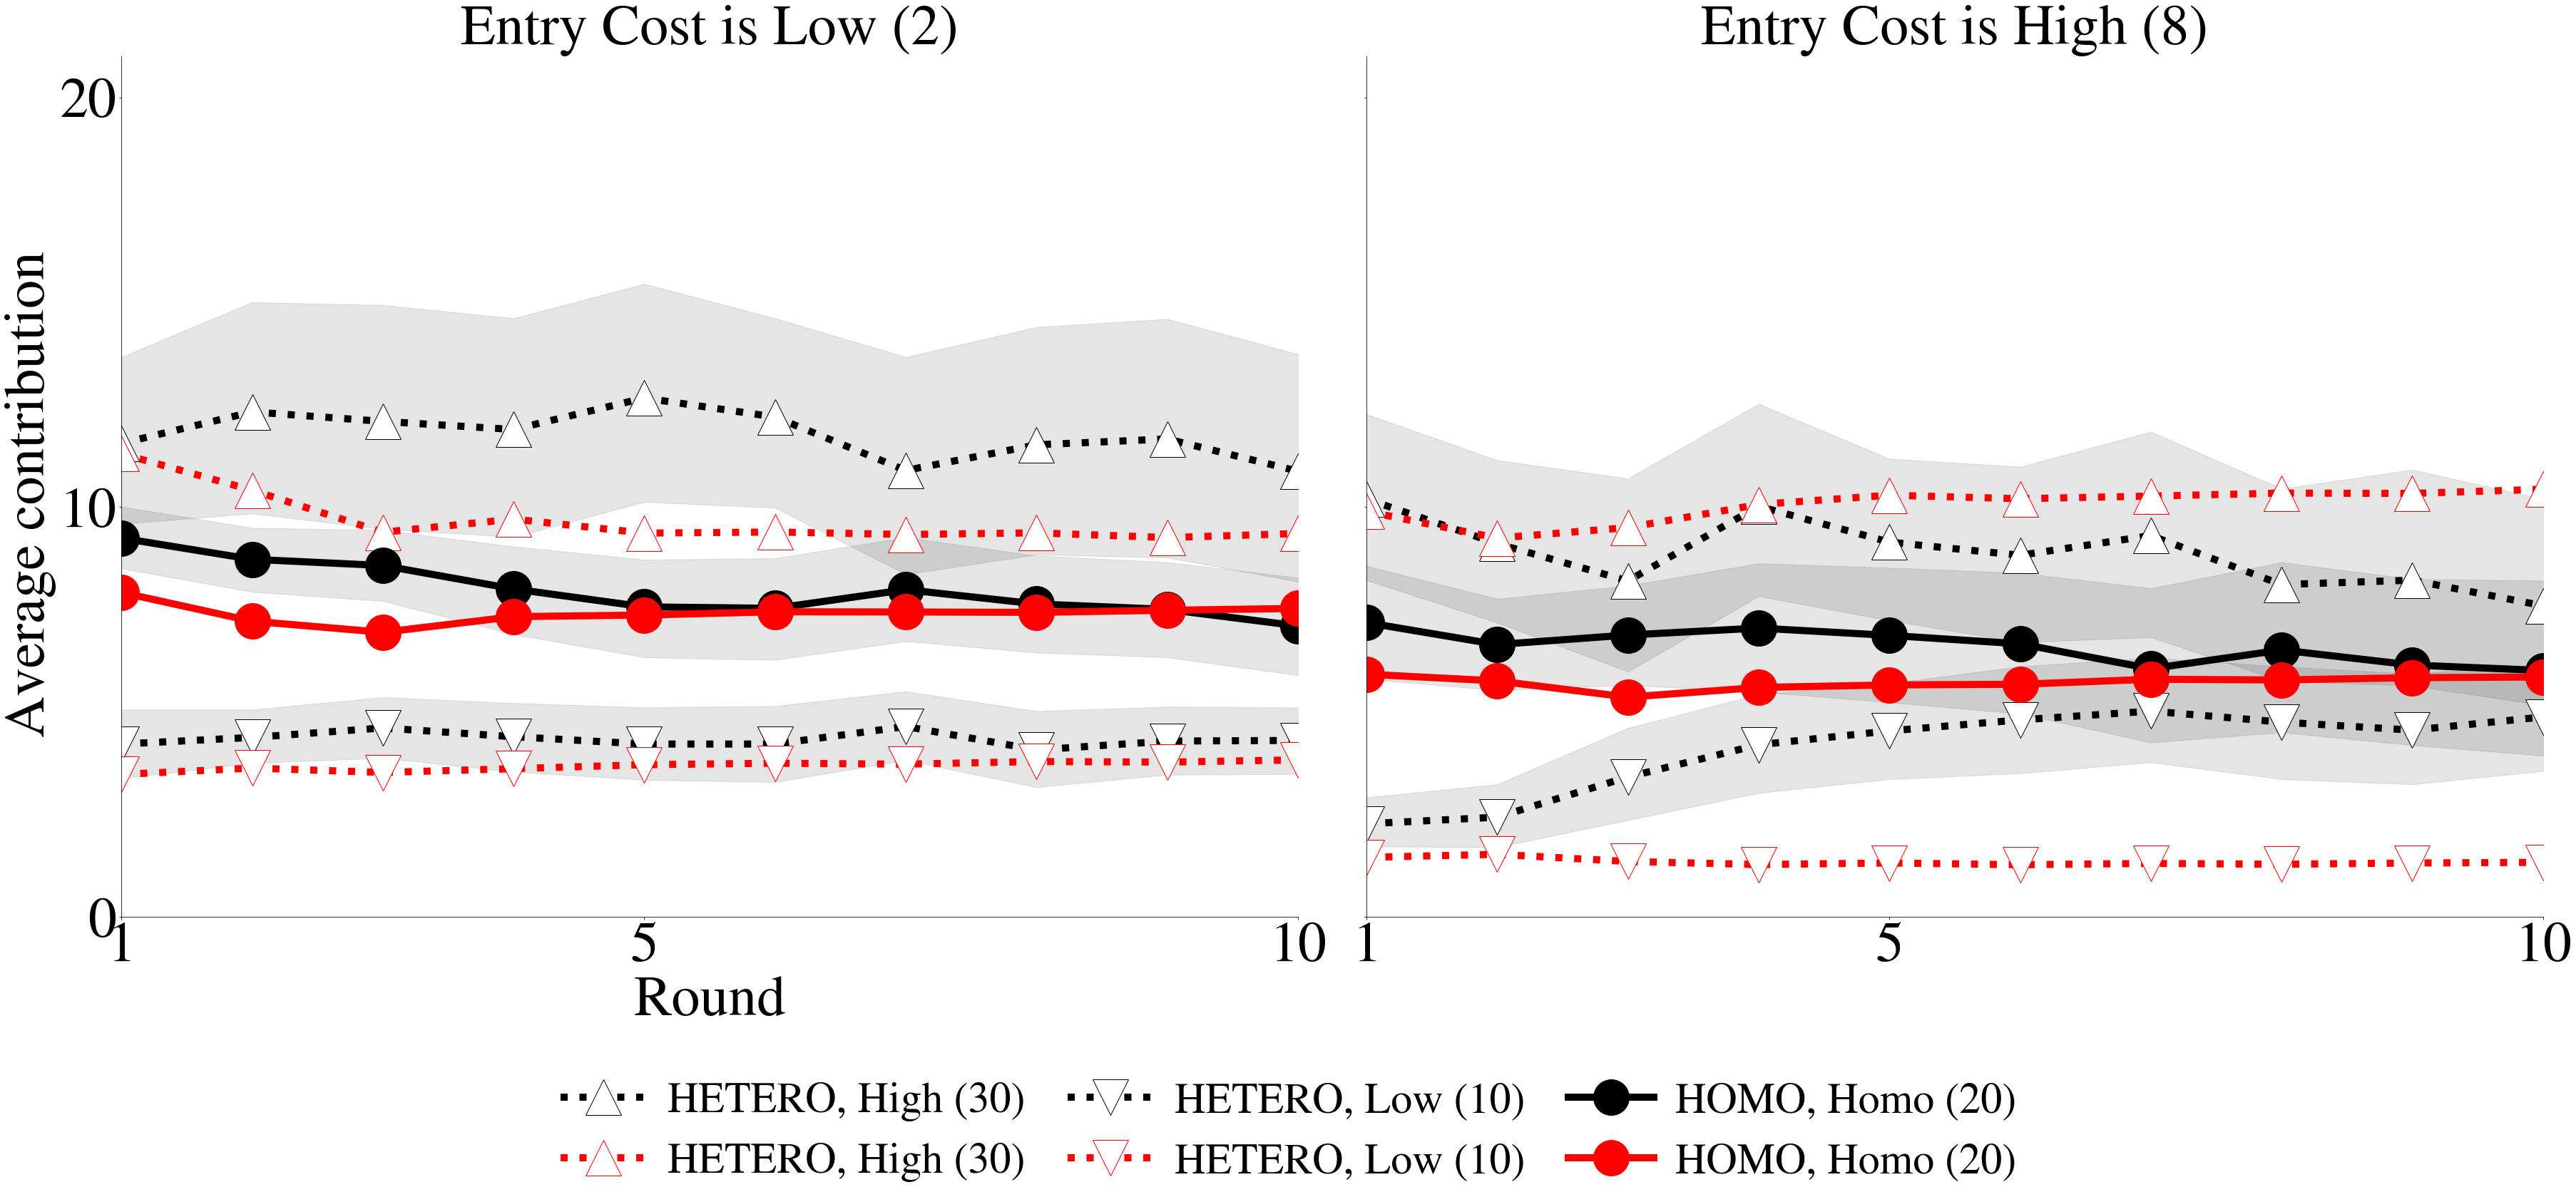

In [24]:
# Contribution Level

treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']

# For the simulated data

treatment_var = 'T_endw_comp'
var_of_interest =  'tot_contr'
LocalOnly = data_OpporSim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

dfSimcl = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lSimcl = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_uSimcl = pd.DataFrame(output[2,:,:], columns = treatment_list_r)


# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_rSimcl = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lrSimcl = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_urSimcl = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

### This is to create the graph for all rounds



pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 21)
custom_ytick = np.arange(0,21,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': '^',
                    'HETERO, Low (10)': 'v',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_markerfacecolor_s = ['white', 'white','red']
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df_contrlev[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=50 )
    axes[0].fill_between(df_contrlev_ci_u.index, df_contrlev_ci_u[yy],df_contrlev_ci_l[yy], alpha=0.1, color=custom_markercolor[j])
    axes[0].plot(dfSimcl[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=50 )
#     axes[0].fill_between(df_ci_uSimcl.index, df_ci_uSimcl[yy],df_ci_lSimcl[yy], alpha=0.1, color='red')

    
axes[0].set_xlabel('Round', fontsize=80)
axes[0].set_ylabel('Average contribution ', fontsize=80)
axes[0].set_title('Entry Cost is Low (2)', fontsize=80)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_contrlev_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=50 )
    axes[1].fill_between(df_contrlev_ci_ur.index, df_contrlev_ci_ur[yy],df_contrlev_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])
    axes[1].plot(df_rSimcl[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=50 )
#     axes[1].fill_between(df_ci_urSimcl.index, df_ci_urSimcl[yy],df_ci_lrSimcl[yy], alpha=0.1, color='red')

axes[1].set_title('Entry Cost is High (8)', fontsize=80)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=80)
    axes[i].tick_params(axis='y', labelsize=80)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=3 , fontsize=60,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
# fig.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simclulation-Local-Global-Contribution-add-simulation2.pdf', bbox_inches="tight" )  




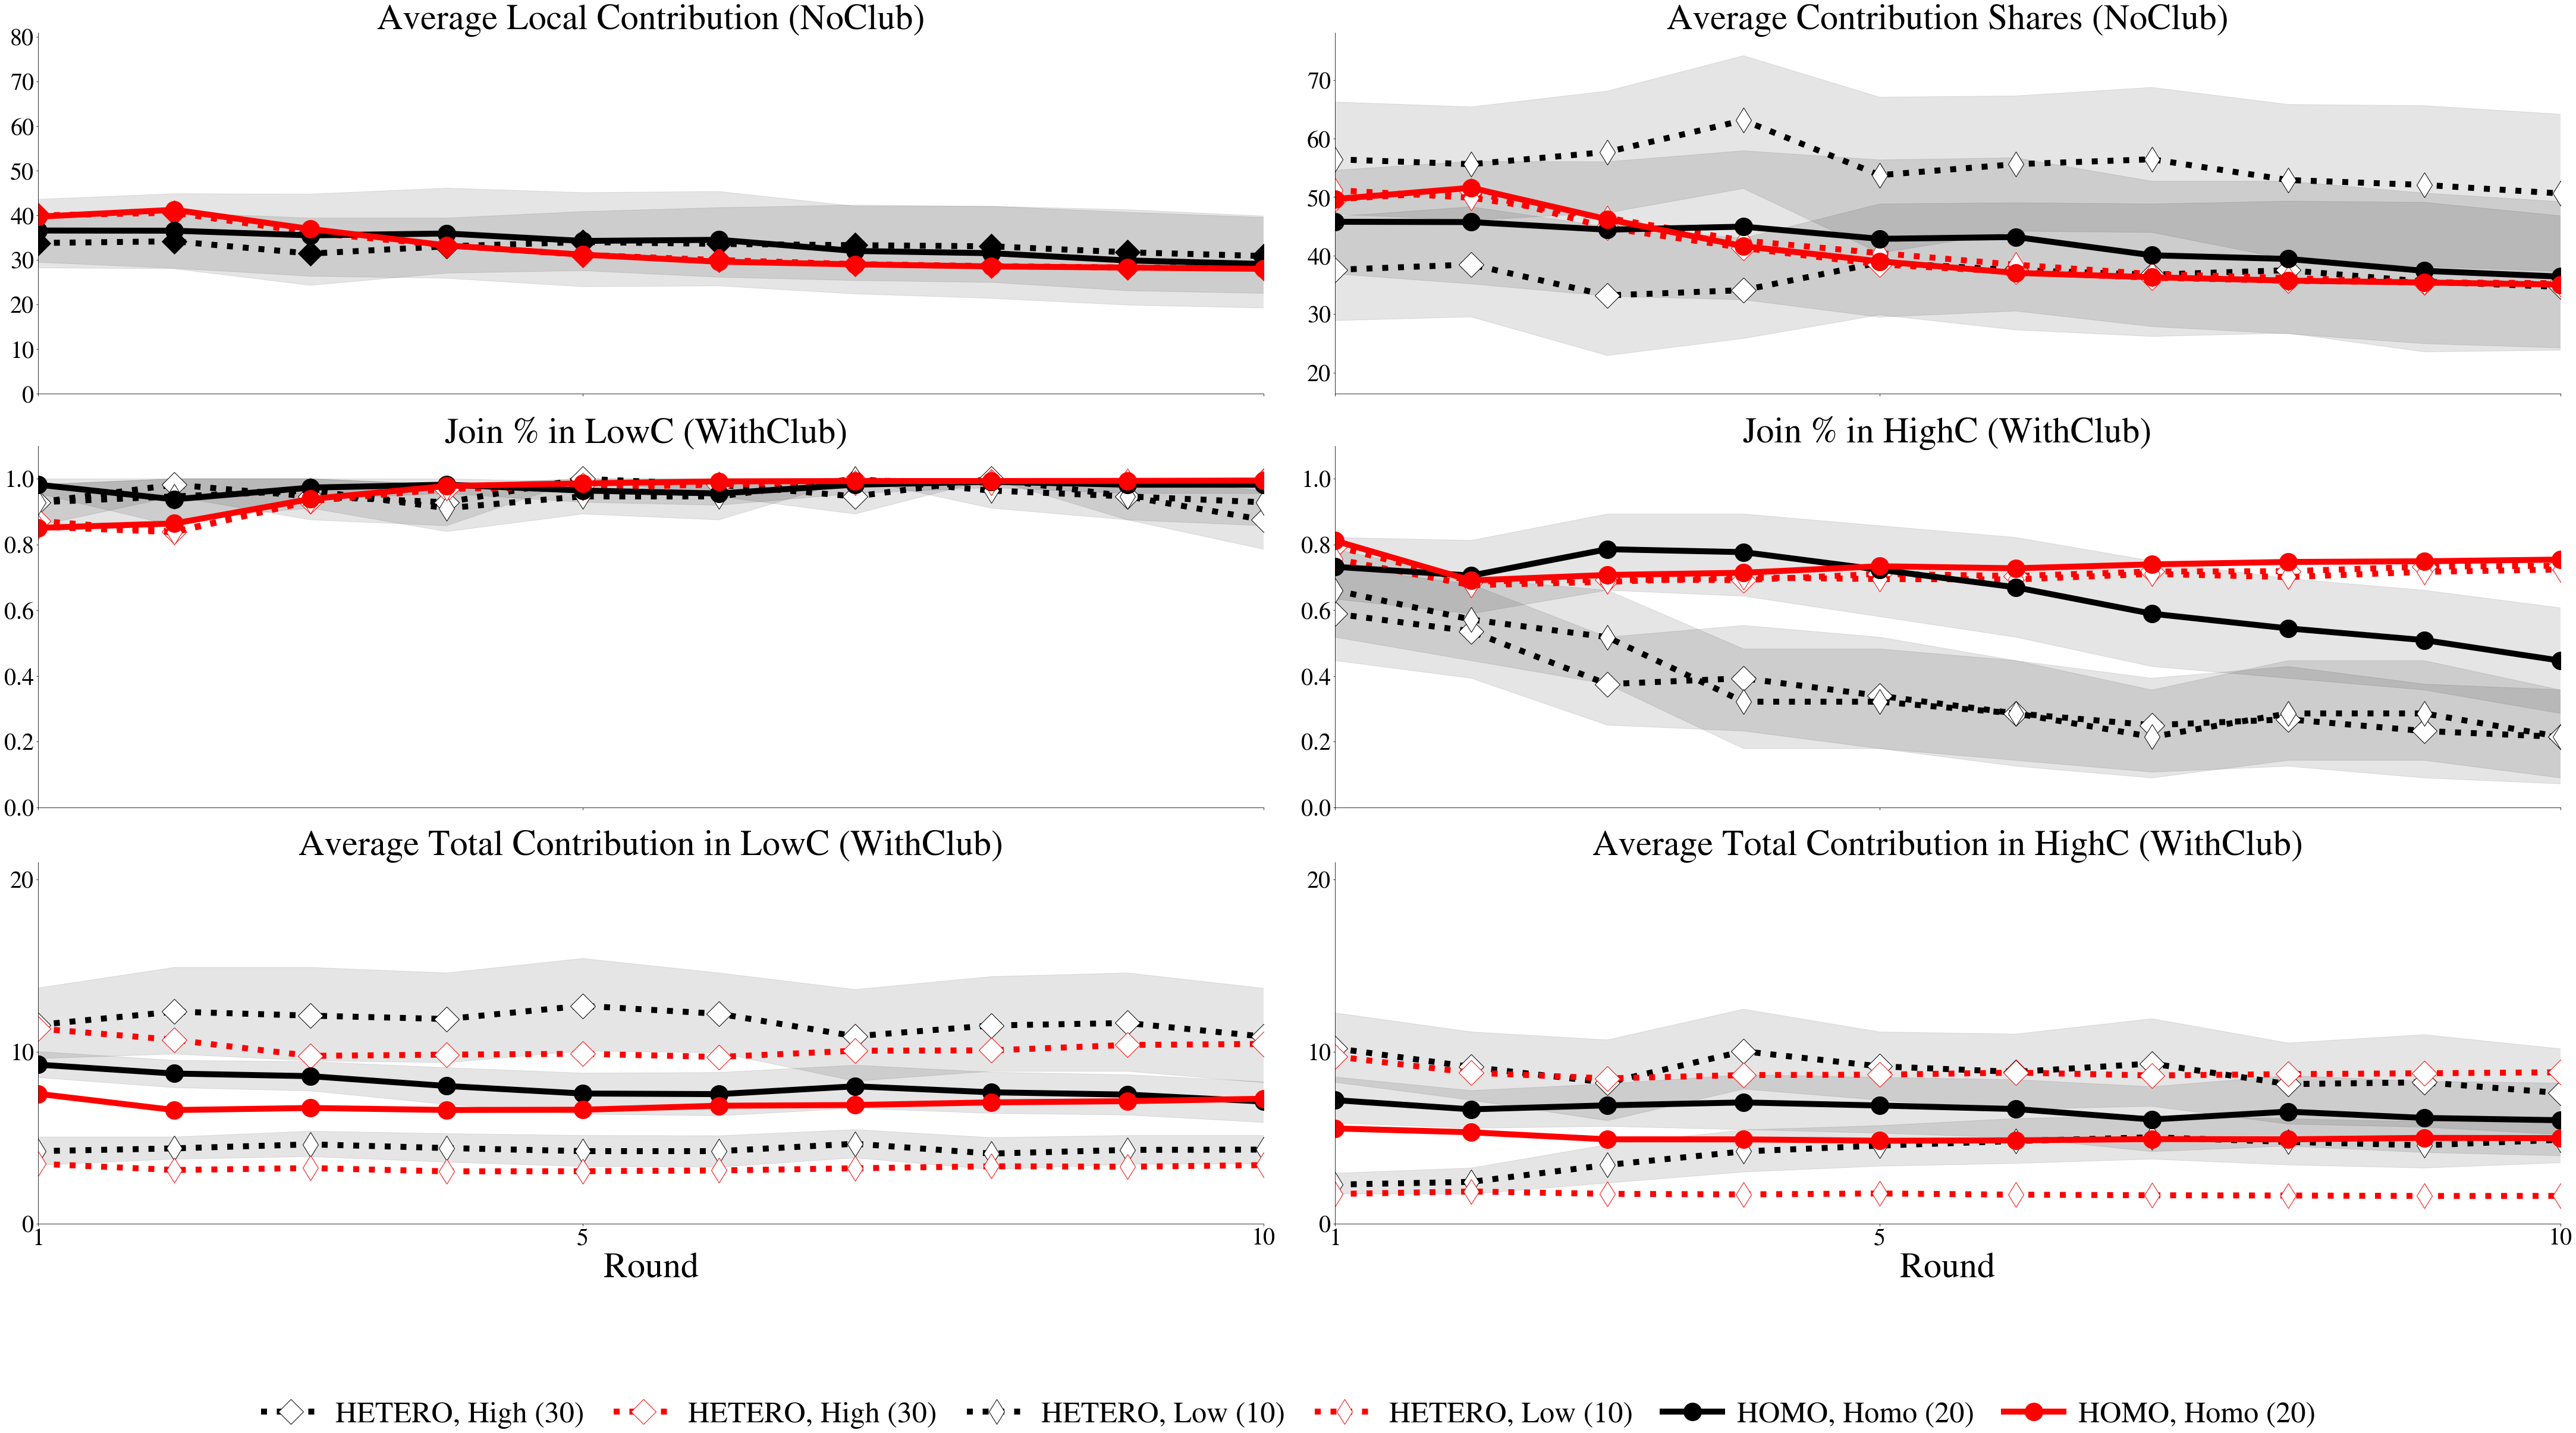

In [40]:
# Try to conbine all graphs into a 2X3 pannel


### Compare with Simulation results

pd.set_option('plotting.backend', 'matplotlib')

fig, axes = plt.subplots(nrows=3, ncols=2,  sharex=True,  
                         constrained_layout=True, figsize=(60, 30))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 81)
custom_xtick = np.array([0,4,9,14,19])
custom_ytick = np.arange(0,81,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0,0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o',
                     }
    
custom_markercolor = ['black', 'black', ]
custom_markerfacecolor = ['black', 'black']
custom_linestyle = [':','-']

# NoClub: contribution 
for j, yy in enumerate(treatment_list):
    axes[0,0].plot(df_local[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0,0].fill_between(df_local_ci_u.index, df_local_ci_u[yy],df_local_ci_l[yy], alpha=0.1, color=custom_markercolor[j])
    axes[0,0].plot(dfSim[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor='red',
                         linewidth=10,  markersize=30 )
#     axes[0].fill_between(df_ci_uSim.index, df_ci_uSim[yy],df_ci_lSim[yy], alpha=0.1, color='red')

    
# axes[0,0].set_xlabel('Round', fontsize=60)
# axes[0,0].set_ylabel('Average group contribution (NoClub)', fontsize=60)
axes[0,0].set_title('Average Local Contribution (NoClub)', fontsize=60)




# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_markerfacecolor_s = ['white', 'white','red']
custom_linestyle = [':',':','-']


# NoClub: contribution shares
for j, yy in enumerate(treatment_list_r):
    axes[0,1].plot(df_local_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0,1].fill_between(df_local_ci_ur.index, df_local_ci_ur[yy],df_local_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])
    axes[0,1].plot(df_rSim[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=30 )
#     axes[1].fill_between(df_ci_urSim.index, df_ci_urSim[yy],df_ci_lrSim[yy], alpha=0.1, color='red')
    
# axes[0,1].set_xlabel('Round', fontsize=60)
# axes[0,1].set_ylabel('Average contribution shares (%) ', fontsize=60)
axes[0,1].set_title('Average Contribution Shares (NoClub)', fontsize=60)


##################Second row, WithClub, Join behaviors

custom_xlim = (0, 9)
custom_ylim = (0, 1.1)
custom_ytick = np.arange(0,1.1,step=0.2)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[1,0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_markerfacecolor_s = ['white', 'white','red']
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[1,0].plot(df_join[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1,0].fill_between(df_join_ci_u.index, df_join_ci_u[yy],df_join_ci_l[yy], alpha=0.1, color=custom_markercolor[j])
    axes[1,0].plot(dfSimj[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=30 )
#     axes[0].fill_between(df_ci_uSim.index, df_ci_uSim[yy],df_ci_lSim[yy], alpha=0.1, color='red')

    
# axes[1,0].set_xlabel('Round', fontsize=60)
# axes[1,0].set_ylabel('Average Ratio who joined the club (%) ', fontsize=60)
axes[1,0].set_title('Join % in LowC (WithClub) ', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1,1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1,1].plot(df_join_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1,1].fill_between(df_join_ci_ur.index, df_join_ci_ur[yy],df_join_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])
    axes[1,1].plot(df_rSimj[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=30 )
    axes[1,1].fill_between(df_ci_urSim.index, df_ci_urSim[yy],df_ci_lrSim[yy], alpha=0.1, color='red')

axes[1,1].set_title('Join % in HighC (WithClub)', fontsize=60)




### Contribution level 
custom_xlim = (0, 9)
custom_ylim = (0, 21)
custom_ytick = np.arange(0,21,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[2,0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)
for j, yy in enumerate(treatment_list_r):
    axes[2,0].plot(df_contrlev[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[2,0].fill_between(df_contrlev_ci_u.index, df_contrlev_ci_u[yy],df_contrlev_ci_l[yy], alpha=0.1, color=custom_markercolor[j])
    axes[2,0].plot(dfSimcl[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=30 )

    
axes[2,0].set_xlabel('Round', fontsize=60)
# axes[2,0].set_ylabel('Average contribution ', fontsize=60)
axes[2,0].set_title('Average Total Contribution in LowC (WithClub)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[2,1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[2,1].plot(df_contrlev_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[2,1].fill_between(df_contrlev_ci_ur.index, df_contrlev_ci_ur[yy],df_contrlev_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])
    axes[2,1].plot(df_rSimcl[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=30 )

axes[2,1].set_title('Average Total Contribution in HighC (WithClub)', fontsize=60)
axes[2,1].set_xlabel('Round', fontsize=60)


for j in range(3):
    for i in range(2):
        axes[j,i].spines['top'].set_visible(False)
        axes[j,i].spines['right'].set_visible(False)  
        axes[j,i].tick_params(axis='x', labelsize=40)
        axes[j,i].tick_params(axis='y', labelsize=40)

handles, labels = axes[1,0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
# fig.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simulation-All.pdf', bbox_inches="tight" )  


In [27]:
# Tradeoff

data_noOppor.columns

Index(['subsession.round_number', 'subsession.period', 'subsession.sg',
       'player.id_in_group', 'player.endowment', 'player.join_club',
       'player.local_community', 'player.id_in_local',
       'player.contribution_local', 'player.contribution_global',
       'player.total_contribution_local', 'player.individual_share_local',
       'player.payoff', 'group.id_in_subsession', 'group.FC',
       'group.total_contribution_global', 'group.individual_share_global',
       'session.code', 'Treatment', 'FC', 'participant.code', 'endowment',
       'endowment_j', 'endowment_nj', 'tot_contr', 'privateAcc',
       'player.payoff_globalagg', 'player.endowment_globalagg', 'Efficiency',
       'Sequence', 'End_level', 'tot_cont_share', 'T_endw_comp'],
      dtype='object')

In [28]:
MergedPays

NameError: name 'MergedPays' is not defined

In [ ]:
# Welfare counterfactual
var_of_interest =  'player.payoff'
treatment_var = 'Treatment'
localPays_t = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC','Sequence','subsession.round_number', 'subsession.period'
            ])[var_of_interest].sum().reset_index()

localPays = localPays_t.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC',
            ])[var_of_interest].mean().reset_index()


GlobalPays_t = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC','subsession.round_number', 'subsession.period'
            ])[var_of_interest].sum().reset_index()

GlobalPays = GlobalPays_t.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC',
            ])[var_of_interest].mean().reset_index()

MergedPays = localPays.merge(GlobalPays, on=[ treatment_var,
    'player.local_community',  'session.code','FC'])
MergedPays['Welfare'] = MergedPays['player.payoff_y'] - MergedPays['player.payoff_x']



In [ ]:
MergedPays.set_index('FC', inplace=True)
# MergedPays.groupby([  treatment_var,'FC'])['Welfare'].mean().plot(legend=True)
# MergedPays.groupby([  treatment_var,'FC'])['Welfare'].mean().reset_index()

fig = MergedPays.pivot_table(index='FC', columns=treatment_var, values='Welfare').plot(kind='bar')
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
fig.spines['bottom'].set_position('zero')  
fig.legend(bbox_to_anchor=(.5,-0.1), loc="center" , ncol=4)
fig.set_ylabel('Average welfare difference')
fig.figure.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simulation-Payoff-Experiment.pdf'  , bbox_inches="tight")  


In [ ]:
# Welfare counterfactual
var_of_interest =  'player.payoff'
treatment_var = 'T_endw_comp'
localPays_t = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC','Sequence','subsession.round_number', 'subsession.period'
            ])[var_of_interest].sum().reset_index()

localPays = localPays_t.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC',
            ])[var_of_interest].mean().reset_index()


GlobalPays_t = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC','subsession.round_number', 'subsession.period'
            ])[var_of_interest].sum().reset_index()

GlobalPays = GlobalPays_t.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC',
            ])[var_of_interest].mean().reset_index()

MergedPays = localPays.merge(GlobalPays, on=[ treatment_var,
    'player.local_community',  'session.code','FC'])
MergedPays['Welfare'] = MergedPays['player.payoff_y'] - MergedPays['player.payoff_x']

MergedPays.set_index('FC', inplace=True)
# MergedPays.groupby([  treatment_var,'FC'])['Welfare'].mean().plot(legend=True)
# MergedPays.groupby([  treatment_var,'FC'])['Welfare'].mean().reset_index()

fig = MergedPays.pivot_table(index='FC', columns=treatment_var, values='Welfare').plot(kind='bar')
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
fig.spines['bottom'].set_position('zero')  
fig.legend(bbox_to_anchor=(.5,-0.1), loc="center" , ncol=4)
fig.set_ylabel('Average welfare difference')
# fig.figure.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simulation-Payoff-Experiment.pdf'  , bbox_inches="tight")  


## Welfare Counterfactual

-Return : [Start Data Analysis](#Start-Data-Analysis)

In [3]:
# Counterfactual data import


# path = '..//..//Model//SimulatedResults//20-IEL-CounterFactual//'
# name = 'BABp_0.48_b_22_g_8_fx_10' # For experimental parameters 
# name = 'ChangingWeight_BABp_0.48_b_22_g_8_fx_10'
# CounterfactualData = pd.read_csv(path+name+'.csv')



# Imported the counterfactual data

path = '..//..//Model//SimulatedResults//20-IEL-CounterFactual//'
# name = 'ML6_MG4_p_0.48_b_22_g_8_fx_10'
# name = 'ML5_MG5_p_0.48_b_22_g_8_fx_10'
# name = 'ML4_MG4_p_0.48_b_22_g_8_fx_10'
# name = 'ML7_MG7_p_0.48_b_22_g_8_fx_10'



CounterfactualData = pd.DataFrame()
for mpcr in range(3,8):
    temp = pd.read_csv(path+'ML'+str(mpcr)+'_MG'+str(mpcr)+'_p_0.48_b_22_g_8_fx_10.csv')
    temp['MPCR'] = 0.1*mpcr
    CounterfactualData = pd.concat([CounterfactualData, temp])
    
    
CounterfactualData2 = pd.DataFrame()
for mpcr in range(4,8):
    temp = pd.read_csv(path+'ML6'+'_MG'+str(mpcr)+'_p_0.48_b_22_g_8_fx_10.csv')
    temp['MPCR'] = 0.1*mpcr
    CounterfactualData2 = pd.concat([CounterfactualData2, temp])
    

CounterfactualData3 = pd.DataFrame()
for mpcr in range(4,8):
    temp = pd.read_csv(path+'ML'+str(mpcr)+'_MG6'+'_p_0.48_b_22_g_8_fx_10.csv')
    temp['MPCR'] = 0.1*mpcr
    CounterfactualData3 = pd.concat([CounterfactualData3, temp])

In [6]:
CounterfactualData2['player.payoff'].mean()

31.814057275375188

In [7]:
CounterfactualData3['player.payoff'].mean()

31.92547916812389

In [21]:
data_noOppor_sim = CounterfactualData[CounterfactualData['Sequence']=='A2_bab']

data_noOppor_sim['tot_contr'] = data_noOppor_sim['player.contribution_local']
data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['player.contribution_local'] / data_noOppor_sim['endow_org']
data_noOppor_sim['End_level'] = "High (30)"
data_noOppor_sim.loc[data_noOppor_sim['endow_org']==10,'End_level'] = "Low (10)"
data_noOppor_sim.loc[data_noOppor_sim['endow_org']==20,'End_level'] = "Homo (20)"
data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['tot_contr'] / data_noOppor_sim['endow_org'] * 100
data_noOppor_sim['T_endw_comp']= data_noOppor_sim['Treatment'] + ', ' + data_noOppor_sim['End_level']




C:\Users\xinxi\AppData\Local\Temp/ipykernel_23204/3418126403.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noOppor_sim['tot_contr'] = data_noOppor_sim['player.contribution_local']
C:\Users\xinxi\AppData\Local\Temp/ipykernel_23204/3418126403.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['player.contribution_local'] / data_noOppor_sim['endow_org']
C:\Users\xinxi\AppData\Local\Temp/ipykernel_23204/3418126403.py:5: SettingWithCopyWarning: 
A

In [22]:
# CounterfactualData_cut
# For the simulated results
# Data local + global 
# data_OpporSim = CounterfactualData_cut[CounterfactualData_cut['Sequence']=='B1_bab']
data_OpporSim = CounterfactualData[CounterfactualData['Sequence']=='B1_bab']

data_OpporSim['End_level'] = "Homo (20)" 
data_OpporSim['tot_contr'] = data_OpporSim['player.contribution_local'] + np.nan_to_num(data_OpporSim['player.contribution_global'])
data_OpporSim['endowment'] = data_OpporSim['endow_org'] - 1*(1-np.isnan(data_OpporSim['player.contribution_global']))*data_OpporSim['FC']/10
data_OpporSim.loc[data_OpporSim['endow_org']<=10,'End_level'] = "Low (10)"
data_OpporSim.loc[data_OpporSim['endow_org']>20,'End_level'] = "High (30)"


data_OpporSim['tot_cont_share'] = data_OpporSim['tot_contr'] / data_OpporSim['endowment'] * 100
data_OpporSim['T_endw_comp']= data_OpporSim['Treatment'] + ', ' + data_OpporSim['End_level']
data_OpporSim['local_share'] = data_OpporSim['player.contribution_local']/ data_OpporSim['endowment'] * 100
data_OpporSim['global_share'] = data_OpporSim['player.contribution_global']/ data_OpporSim['endowment'] * 100

data_OpporSim['player.join_club'] = 1-np.isnan(data_OpporSim['player.contribution_global'])
# data_OpporSim.loc[(data_OpporSim['endowment']==10) & (data_OpporSim['player.join_club']==1) & (data_OpporSim['FC']==100) ,'End_level'] = "Homo (20)"
# data_OpporSim.loc[(data_OpporSim['endowment']==20) & (data_OpporSim['player.join_club']==1) & (data_OpporSim['FC']==100) ,'End_level'] = "High (30)"


C:\Users\xinxi\AppData\Local\Temp/ipykernel_23204/3024599332.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_OpporSim['End_level'] = "Homo (20)"
C:\Users\xinxi\AppData\Local\Temp/ipykernel_23204/3024599332.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_OpporSim['tot_contr'] = data_OpporSim['player.contribution_local'] + np.nan_to_num(data_OpporSim['player.contribution_global'])
C:\Users\xinxi\AppData\Local\Temp/ipykernel_23204/3024599332.py:9: SettingWithCopyWarning: 
A value is trying to

In [37]:
var_of_interest =  'player.payoff'
treatment_var = 'Treatment'
# treatment_var = 'T_endw_comp'
localPays_t = data_noOppor_sim.groupby([ 
                      treatment_var,'MPCR',
    'player.local_community',  'session_num','FC','Sequence','subsession.round_number', 'subsession.period'
            ])[var_of_interest].sum().reset_index()

localPays = localPays_t.groupby([ 
                      treatment_var,'MPCR',
    'player.local_community',  'session_num','FC',
            ])[var_of_interest].mean().reset_index()


GlobalPays_t = data_OpporSim.groupby([ 
                      treatment_var,'MPCR',
    'player.local_community',  'session_num','FC','subsession.round_number', 'subsession.period'
            ])[var_of_interest].sum().reset_index()

GlobalPays = GlobalPays_t.groupby([ 
                      treatment_var,'MPCR',
    'player.local_community',  'session_num','FC',
            ])[var_of_interest].mean().reset_index()

MergedPays = localPays.merge(GlobalPays, on=[ treatment_var,'MPCR',
    'player.local_community',  'session_num','FC'])
MergedPays['Welfare'] = MergedPays['player.payoff_y'] - MergedPays['player.payoff_x']


# MergedPays.groupby([  treatment_var,'FC'])['Welfare'].mean().plot(legend=True)
# MergedPays.groupby([  treatment_var,'FC'])['Welfare'].mean().reset_index()

In [38]:
# # Old Bar graphs
# GroupedData = MergedPays.groupby(['Treatment', 'MPCR', 'FC'])['Welfare'].mean().reset_index()
# fig, axes = plt.subplots(nrows=5, ncols=1,  sharex=True,   sharey=True,  
#                          constrained_layout=True, )
# fig.set_constrained_layout_pads( w_pad=1 / 100)


# for i,m in enumerate(GroupedData['MPCR'].unique()):
#     x = GroupedData[GroupedData['MPCR']==m]
#     x1 =x[x['Treatment']=='HETERO']
#     x1.set_index('FC', inplace=True)
#     axes[i].bar(x1.index-0.5, x1['Welfare'], label='HETERO', color='blue')
#     x1 =x[x['Treatment']=='HOMO']
#     x1.set_index('FC', inplace=True)
#     axes[i].bar(x1.index+0.5, x1['Welfare'], label='HOMO', color='red')
    
#     axes[i].spines['top'].set_visible(False)
#     axes[i].spines['right'].set_visible(False)
#     axes[i].spines['bottom'].set_position('zero')
#     mm =int(i+3)/10
#     axes[i].set_title('$m_l=m_g=$'+str(mm))

# x_labels = [str(i) for i in range(11)]
# axes[4].set_xticks(np.arange(0,110,10))
# axes[4].set_xticklabels(x_labels)
# axes[4].set_xlabel('Entry Cost')
# axes[2].set_ylabel('Welfare Difference')
# handles, labels = axes[0].get_legend_handles_labels() 
# fig.legend(handles, labels ,bbox_to_anchor=(.5,-0.1), loc="center" , ncol=4)
# fig.figure.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simulation-Payoff-Simulation-Difference.pdf'  , bbox_inches="tight")  


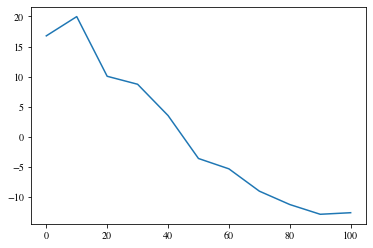

In [39]:
GroupedData
HOMO = GroupedData[GroupedData['Treatment']=='HOMO']
HOMO_1set = HOMO[HOMO['MPCR']==0.4]
fig = plt.figure()
ax = plt.axes()

ax.plot(HOMO_1set['FC'], HOMO_1set['Welfare'])

In [40]:
GroupedData['MPCR'].unique()

array([0.3, 0.4, 0.5, 0.6, 0.7])

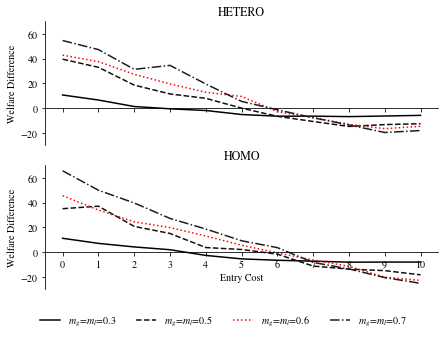

In [49]:
# New: make all of them in one graph as lines

GroupedData = MergedPays.groupby(['Treatment', 'MPCR', 'FC'])['Welfare'].mean().reset_index()
fig, axes = plt.subplots(nrows=2, ncols=1,  sharex=True,   sharey=True,  
                         constrained_layout=True, )
fig.set_constrained_layout_pads( w_pad=1 / 100)

# colors = ['black','darkgrey', ]
lines = ["-","--","-.",":",'.']

weights = np.arange(1, 20)

norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.gray)
j = 0
for i,m in enumerate(GroupedData['MPCR'].unique()):
    if i in [0,2,4]:
        
        x = GroupedData[GroupedData['MPCR']==m]
        mm =int(i+3)/10
        x1 =x[x['Treatment']=='HETERO']
    #     x1.set_index('FC', inplace=True)
        axes[0].plot(x1['FC'], x1['Welfare'], label='$m_g$=$m_l$='+str(mm), 
                     color=cmap.to_rgba(j+1), linestyle=lines[j],)
        axes[0].set_title('HETERO')
        x1 =x[x['Treatment']=='HOMO']
    #     x1.set_index('FC', inplace=True)
        axes[1].plot(x1['FC'], x1['Welfare'],
                     color=cmap.to_rgba(j+1), linestyle=lines[j],)
#          label='HOMO, MPCR='+str(mm), 
        axes[1].set_title('HOMO')
        
        j += 1 
    if i == 3:
        x = GroupedData[GroupedData['MPCR']==m]
        mm =int(i+3)/10
        x1 =x[x['Treatment']=='HETERO']
    #     x1.set_index('FC', inplace=True)
        axes[0].plot(x1['FC'], x1['Welfare'], label='$m_g$=$m_l$='+str(mm), 
                     color='red', linestyle=lines[3],)
        axes[0].set_title('HETERO')
        x1 =x[x['Treatment']=='HOMO']
    #     x1.set_index('FC', inplace=True)
        axes[1].plot(x1['FC'], x1['Welfare'],
                     color='red', linestyle=lines[3],)
#          label='HOMO, MPCR='+str(mm), 
        axes[1].set_title('HOMO')
        
        
for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_position('zero')
    axes[i].set_ylabel('Welfare Difference')

x_labels = [str(i) for i in range(11)]
axes[1].set_xticks(np.arange(0,110,10))
axes[1].set_xticklabels(x_labels)
axes[1].set_xlabel('Entry Cost')

handles, labels = axes[0].get_legend_handles_labels() 
handles2, labels2 = axes[1].get_legend_handles_labels() 
# Handles = handles + handles2
# Labels = labels + labels2
# Order = [0,3,1,4,2,5]
# fig.legend([Handles[idx] for idx in Order],[Labels[idx] for idx in Order],
#            bbox_to_anchor=(.5,-0.1), loc="center" , ncol=3)
           
fig.legend(bbox_to_anchor=(.5,-0.1), loc="center" , ncol=4, frameon=False,)
fig.figure.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simulation-Payoff-Simulation-Difference.pdf'  , bbox_inches="tight")  


In [8]:
# A second simulation
data_noOppor_sim = CounterfactualData2[CounterfactualData2['Sequence']=='A2_bab']

data_noOppor_sim['tot_contr'] = data_noOppor_sim['player.contribution_local']
data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['player.contribution_local'] / data_noOppor_sim['endow_org']
data_noOppor_sim['End_level'] = "High (30)"
data_noOppor_sim.loc[data_noOppor_sim['endow_org']==10,'End_level'] = "Low (10)"
data_noOppor_sim.loc[data_noOppor_sim['endow_org']==20,'End_level'] = "Homo (20)"
data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['tot_contr'] / data_noOppor_sim['endow_org'] * 100
data_noOppor_sim['T_endw_comp']= data_noOppor_sim['Treatment'] + ', ' + data_noOppor_sim['End_level']


# CounterfactualData2_cut
# For the simulated results
# Data local + global 
# data_OpporSim = CounterfactualData2_cut[CounterfactualData2_cut['Sequence']=='B1_bab']
data_OpporSim = CounterfactualData2[CounterfactualData2['Sequence']=='B1_bab']

data_OpporSim['End_level'] = "Homo (20)" 
data_OpporSim['tot_contr'] = data_OpporSim['player.contribution_local'] + np.nan_to_num(data_OpporSim['player.contribution_global'])
data_OpporSim['endowment'] = data_OpporSim['endow_org'] - 1*(1-np.isnan(data_OpporSim['player.contribution_global']))*data_OpporSim['FC']/10
data_OpporSim.loc[data_OpporSim['endow_org']<=10,'End_level'] = "Low (10)"
data_OpporSim.loc[data_OpporSim['endow_org']>20,'End_level'] = "High (30)"


data_OpporSim['tot_cont_share'] = data_OpporSim['tot_contr'] / data_OpporSim['endowment'] * 100
data_OpporSim['T_endw_comp']= data_OpporSim['Treatment'] + ', ' + data_OpporSim['End_level']
data_OpporSim['local_share'] = data_OpporSim['player.contribution_local']/ data_OpporSim['endowment'] * 100
data_OpporSim['global_share'] = data_OpporSim['player.contribution_global']/ data_OpporSim['endowment'] * 100

data_OpporSim['player.join_club'] = 1-np.isnan(data_OpporSim['player.contribution_global'])
# data_OpporSim.loc[(data_OpporSim['endowment']==10) & (data_OpporSim['player.join_club']==1) & (data_OpporSim['FC']==100) ,'End_level'] = "Homo (20)"
# data_OpporSim.loc[(data_OpporSim['endowment']==20) & (data_OpporSim['player.join_club']==1) & (data_OpporSim['FC']==100) ,'End_level'] = "High (30)"
var_of_interest =  'player.payoff'
treatment_var = 'Treatment'
# treatment_var = 'T_endw_comp'
localPays_t = data_noOppor_sim.groupby([ 
                      treatment_var,'MPCR',
    'player.local_community',  'session_num','FC','Sequence','subsession.round_number', 'subsession.period'
            ])[var_of_interest].sum().reset_index()

localPays = localPays_t.groupby([ 
                      treatment_var,'MPCR',
    'player.local_community',  'session_num','FC',
            ])[var_of_interest].mean().reset_index()


GlobalPays_t = data_OpporSim.groupby([ 
                      treatment_var,'MPCR',
    'player.local_community',  'session_num','FC','subsession.round_number', 'subsession.period'
            ])[var_of_interest].sum().reset_index()

GlobalPays = GlobalPays_t.groupby([ 
                      treatment_var,'MPCR',
    'player.local_community',  'session_num','FC',
            ])[var_of_interest].mean().reset_index()

MergedPays2 = localPays.merge(GlobalPays, on=[ treatment_var,'MPCR',
    'player.local_community',  'session_num','FC'])
MergedPays2['Welfare'] = MergedPays2['player.payoff_y'] - MergedPays2['player.payoff_x']




C:\Users\xinxi\AppData\Local\Temp/ipykernel_23204/1296389099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noOppor_sim['tot_contr'] = data_noOppor_sim['player.contribution_local']
C:\Users\xinxi\AppData\Local\Temp/ipykernel_23204/1296389099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['player.contribution_local'] / data_noOppor_sim['endow_org']
C:\Users\xinxi\AppData\Local\Temp/ipykernel_23204/1296389099.py:6: SettingWithCopyWarning: 
A

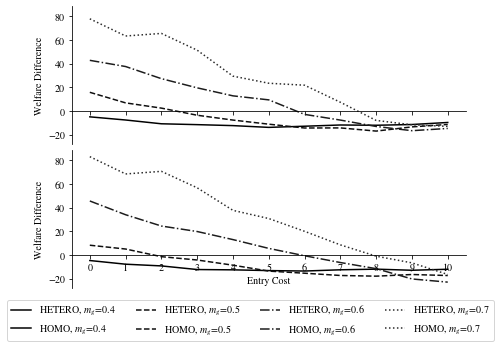

In [9]:
	
# New: make all of them in one graph as lines (change mg)

GroupedData = MergedPays2.groupby(['Treatment', 'MPCR', 'FC'])['Welfare'].mean().reset_index()
fig, axes = plt.subplots(nrows=2, ncols=1,  sharex=True,   sharey=True,  
                         constrained_layout=True, )
fig.set_constrained_layout_pads( w_pad=1 / 100)


# colors = ['black','darkgrey', ]
lines = ["-","--","-.",":"]

weights = np.arange(1, 20)

norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.gray)

for i,m in enumerate(GroupedData['MPCR'].unique()):
    x = GroupedData[GroupedData['MPCR']==m]
    mm =int(i+4)/10
    x1 =x[x['Treatment']=='HETERO']
#     x1.set_index('FC', inplace=True)
    axes[0].plot(x1['FC'], x1['Welfare'], label='HETERO, $m_g$='+str(mm),
                 color=cmap.to_rgba(i+1), linestyle=lines[i],)
    x1 =x[x['Treatment']=='HOMO']
#     x1.set_index('FC', inplace=True)
    axes[1].plot(x1['FC'], x1['Welfare'], label='HOMO, $m_g$='+str(mm), color=cmap.to_rgba(i+1),linestyle=lines[i])

        
        
for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_position('zero')
    axes[i].set_ylabel('Welfare Difference')

x_labels = [str(i) for i in range(11)]
axes[1].set_xticks(np.arange(0,110,10))
axes[1].set_xticklabels(x_labels)
axes[1].set_xlabel('Entry Cost')

handles, labels = axes[0].get_legend_handles_labels() 
handles2, labels2 = axes[1].get_legend_handles_labels() 
Handles = handles + handles2
Labels = labels + labels2
Order = [0,4,1,5,2,6,3,7]
fig.legend([Handles[idx] for idx in Order],[Labels[idx] for idx in Order],
           bbox_to_anchor=(.5,-0.1), loc="center" , ncol=4)
# fig.legend(bbox_to_anchor=(.5,-0.1), loc="center" , ncol=3)
fig.figure.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simulation-Payoff-Difference-Change-Mg.pdf'  , bbox_inches="tight")  


In [10]:
# A second simulation
data_noOppor_sim = CounterfactualData3[CounterfactualData3['Sequence']=='A2_bab']

data_noOppor_sim['tot_contr'] = data_noOppor_sim['player.contribution_local']
data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['player.contribution_local'] / data_noOppor_sim['endow_org']
data_noOppor_sim['End_level'] = "High (30)"
data_noOppor_sim.loc[data_noOppor_sim['endow_org']==10,'End_level'] = "Low (10)"
data_noOppor_sim.loc[data_noOppor_sim['endow_org']==20,'End_level'] = "Homo (20)"
data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['tot_contr'] / data_noOppor_sim['endow_org'] * 100
data_noOppor_sim['T_endw_comp']= data_noOppor_sim['Treatment'] + ', ' + data_noOppor_sim['End_level']


# CounterfactualData3_cut
# For the simulated results
# Data local + global 
# data_OpporSim = CounterfactualData3_cut[CounterfactualData3_cut['Sequence']=='B1_bab']
data_OpporSim = CounterfactualData3[CounterfactualData3['Sequence']=='B1_bab']

data_OpporSim['End_level'] = "Homo (20)" 
data_OpporSim['tot_contr'] = data_OpporSim['player.contribution_local'] + np.nan_to_num(data_OpporSim['player.contribution_global'])
data_OpporSim['endowment'] = data_OpporSim['endow_org'] - 1*(1-np.isnan(data_OpporSim['player.contribution_global']))*data_OpporSim['FC']/10
data_OpporSim.loc[data_OpporSim['endow_org']<=10,'End_level'] = "Low (10)"
data_OpporSim.loc[data_OpporSim['endow_org']>20,'End_level'] = "High (30)"


data_OpporSim['tot_cont_share'] = data_OpporSim['tot_contr'] / data_OpporSim['endowment'] * 100
data_OpporSim['T_endw_comp']= data_OpporSim['Treatment'] + ', ' + data_OpporSim['End_level']
data_OpporSim['local_share'] = data_OpporSim['player.contribution_local']/ data_OpporSim['endowment'] * 100
data_OpporSim['global_share'] = data_OpporSim['player.contribution_global']/ data_OpporSim['endowment'] * 100

data_OpporSim['player.join_club'] = 1-np.isnan(data_OpporSim['player.contribution_global'])
# data_OpporSim.loc[(data_OpporSim['endowment']==10) & (data_OpporSim['player.join_club']==1) & (data_OpporSim['FC']==100) ,'End_level'] = "Homo (20)"
# data_OpporSim.loc[(data_OpporSim['endowment']==20) & (data_OpporSim['player.join_club']==1) & (data_OpporSim['FC']==100) ,'End_level'] = "High (30)"
var_of_interest =  'player.payoff'
treatment_var = 'Treatment'
# treatment_var = 'T_endw_comp'
localPays_t = data_noOppor_sim.groupby([ 
                      treatment_var,'MPCR',
    'player.local_community',  'session_num','FC','Sequence','subsession.round_number', 'subsession.period'
            ])[var_of_interest].sum().reset_index()

localPays = localPays_t.groupby([ 
                      treatment_var,'MPCR',
    'player.local_community',  'session_num','FC',
            ])[var_of_interest].mean().reset_index()


GlobalPays_t = data_OpporSim.groupby([ 
                      treatment_var,'MPCR',
    'player.local_community',  'session_num','FC','subsession.round_number', 'subsession.period'
            ])[var_of_interest].sum().reset_index()

GlobalPays = GlobalPays_t.groupby([ 
                      treatment_var,'MPCR',
    'player.local_community',  'session_num','FC',
            ])[var_of_interest].mean().reset_index()

MergedPays3 = localPays.merge(GlobalPays, on=[ treatment_var,'MPCR',
    'player.local_community',  'session_num','FC'])
MergedPays3['Welfare'] = MergedPays3['player.payoff_y'] - MergedPays3['player.payoff_x']




C:\Users\xinxi\AppData\Local\Temp/ipykernel_23204/1669359141.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noOppor_sim['tot_contr'] = data_noOppor_sim['player.contribution_local']
C:\Users\xinxi\AppData\Local\Temp/ipykernel_23204/1669359141.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['player.contribution_local'] / data_noOppor_sim['endow_org']
C:\Users\xinxi\AppData\Local\Temp/ipykernel_23204/1669359141.py:6: SettingWithCopyWarning: 
A

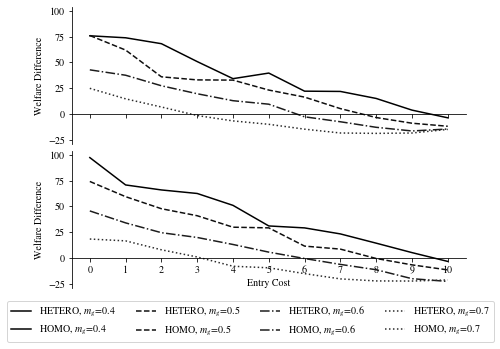

In [11]:

# New: make all of them in one graph as lines

GroupedData = MergedPays3.groupby(['Treatment', 'MPCR', 'FC'])['Welfare'].mean().reset_index()
fig, axes = plt.subplots(nrows=2, ncols=1,  sharex=True,   sharey=True,  
                         constrained_layout=True, )
fig.set_constrained_layout_pads( w_pad=1 / 100)

# colors = ['black','darkgrey', ]
lines = ["-","--","-.",":"]

weights = np.arange(1, 20)

norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.gray)

for i,m in enumerate(GroupedData['MPCR'].unique()):
    x = GroupedData[GroupedData['MPCR']==m]
    mm =int(i+4)/10
    x1 =x[x['Treatment']=='HETERO']
#     x1.set_index('FC', inplace=True)
    axes[0].plot(x1['FC'], x1['Welfare'], label='HETERO, $m_g$='+str(mm),
                 color=cmap.to_rgba(i+1), linestyle=lines[i],)
    x1 =x[x['Treatment']=='HOMO']
#     x1.set_index('FC', inplace=True)
    axes[1].plot(x1['FC'], x1['Welfare'], label='HOMO, $m_g$='+str(mm), color=cmap.to_rgba(i+1),linestyle=lines[i])

        
for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_position('zero')
    axes[i].set_ylabel('Welfare Difference')

x_labels = [str(i) for i in range(11)]
axes[1].set_xticks(np.arange(0,110,10))
axes[1].set_xticklabels(x_labels)
axes[1].set_xlabel('Entry Cost')

handles, labels = axes[0].get_legend_handles_labels() 
handles2, labels2 = axes[1].get_legend_handles_labels() 
Handles = handles + handles2
Labels = labels + labels2
Order = [0,4,1,5,2,6,3,7]
fig.legend([Handles[idx] for idx in Order],[Labels[idx] for idx in Order],
           bbox_to_anchor=(.5,-0.1), loc="center" , ncol=4)
# fig.legend(bbox_to_anchor=(.5,-0.1), loc="center" , ncol=3)
fig.figure.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simulation-Payoff-Difference-Change-Ml.pdf'  , bbox_inches="tight")  


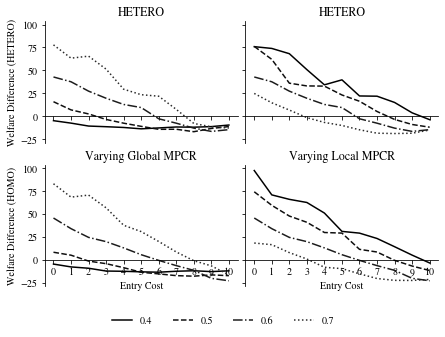

In [26]:
# Combine both (changing m_g and m_l)

# New: make all of them in one graph as lines (change mg)

GroupedData2 = MergedPays2.groupby(['Treatment', 'MPCR', 'FC'])['Welfare'].mean().reset_index()
GroupedData3 = MergedPays3.groupby(['Treatment', 'MPCR', 'FC'])['Welfare'].mean().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=2,  sharex=True,   sharey=True,  
                         constrained_layout=True, )
fig.set_constrained_layout_pads( w_pad=1 / 100)


# colors = ['black','darkgrey', ]
lines = ["-","--","-.",":"]

weights = np.arange(1, 20)

norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.gray)

for i,m in enumerate(GroupedData2['MPCR'].unique()):
    x = GroupedData2[GroupedData2['MPCR']==m]
    mm =int(i+4)/10
    x1 =x[x['Treatment']=='HETERO']
#     x1.set_index('FC', inplace=True)
    axes[0,0].plot(x1['FC'], x1['Welfare'], label=str(mm),
                 color=cmap.to_rgba(i+1), linestyle=lines[i],)
#     label='$m_g$='+str(mm),
    axes[0,0].set_title('HETERO')
    x1 =x[x['Treatment']=='HOMO']
#     x1.set_index('FC', inplace=True)
    axes[1,0].plot(x1['FC'], x1['Welfare'], color=cmap.to_rgba(i+1),linestyle=lines[i])
#     label='HOMO, $m_g$='+str(mm), 
#     axes[1,0].set_title('Keep $m_l=0.6$')
    axes[1,0].set_title('Varying Global MPCR')
        
        
    x = GroupedData3[GroupedData3['MPCR']==m]
    mm =int(i+4)/10
    x1 =x[x['Treatment']=='HETERO']
#     x1.set_index('FC', inplace=True)
    axes[0,1].plot(x1['FC'], x1['Welfare'], 
                 color=cmap.to_rgba(i+1), linestyle=lines[i],)
#     label='$m_l$='+str(mm),
    axes[0,1].set_title('HETERO')
    x1 =x[x['Treatment']=='HOMO']
#     x1.set_index('FC', inplace=True)
    axes[1,1].plot(x1['FC'], x1['Welfare'], color=cmap.to_rgba(i+1),linestyle=lines[i])
#     label='HOMO, $m_g$='+str(mm), 
#     axes[1,1].set_title('Keep $m_g=0.6$')
    axes[1,1].set_title('Varying Local MPCR')
        
for i in range(2):
    for j in range(2):
        axes[i,j].spines['top'].set_visible(False)
        axes[i,j].spines['right'].set_visible(False)
        axes[i,j].spines['bottom'].set_position('zero')
axes[0,0].set_ylabel('Welfare Difference (HETERO)')
axes[1,0].set_ylabel('Welfare Difference (HOMO)')
x_labels = [str(i) for i in range(11)]
axes[0,1].set_xticks(np.arange(0,110,10))
axes[0,1].set_xticklabels(x_labels)
axes[1,1].set_xlabel('Entry Cost')
axes[1,0].set_xlabel('Entry Cost')

# handles, labels = axes[0,0].get_legend_handles_labels() 
# handles2, labels2 = axes[0,1].get_legend_handles_labels() 
# Handles = handles + handles2
# Labels = labels + labels2
# Order = [0,4,1,5,2,6,3,7]
# fig.legend([Handles[idx] for idx in Order],[Labels[idx] for idx in Order],
#            bbox_to_anchor=(.5,-0.1), loc="center" , ncol=4, fontsize=10)
fig.legend(bbox_to_anchor=(.5,-0.1), loc="center" , ncol=4,frameon=False,)
fig.figure.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simulation-Payoff-Difference-Change-1.pdf'  , bbox_inches="tight")  


In [14]:
Labels

['$m_g$=0.4', '$m_g$=0.5', '$m_g$=0.6', '$m_g$=0.7']

In [ ]:
CounterfactualData3.sum()

In [ ]:
CounterfactualData2.sum()

In [ ]:
MergedPays_sim = MergedPays
x = MergedPays_sim[(MergedPays_sim['FC']==20) | (MergedPays_sim['FC']==80)]
x.groupby([  treatment_var,'FC'])['player.payoff_y', 'player.payoff_x', 'Welfare'].mean().reset_index()

In [ ]:
MergedPays

In [ ]:

MergedPays.set_index('FC', inplace=True)
fig = MergedPays.pivot_table(index='FC', columns=treatment_var, values='Welfare').plot(kind='bar')
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
fig.spines['bottom'].set_position('zero')  
fig.legend(bbox_to_anchor=(.5,-0.1), loc="center" , ncol=4)
fig.set_ylabel('Average welfare difference')
# fig.figure.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simulation-Payoff-Simulation-Difference.pdf'  , bbox_inches="tight")  
# fig.figure.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simulation-Payoff-Simulation-Difference-ML4-MG4.pdf'  , bbox_inches="tight")  
# fig.figure.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simulation-Payoff-Simulation-Difference-ML6-MG4.pdf'  , bbox_inches="tight")  


# Double check the data

In [ ]:
var_of_interest =  'player.payoff'
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'

localPays_t = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC','Sequence','subsession.round_number', 'subsession.period'
            ])[var_of_interest].sum().reset_index()

localPays = localPays_t.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC',
            ])[var_of_interest].mean().reset_index()


GlobalPays_t = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC','subsession.round_number', 'subsession.period'
            ])[var_of_interest].sum().reset_index()

GlobalPays = GlobalPays_t.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC',
            ])[var_of_interest].mean().reset_index()

MergedPays = localPays.merge(GlobalPays, on=[ treatment_var,
    'player.local_community',  'session.code','FC'])
MergedPays['Welfare'] = MergedPays['player.payoff_y'] - MergedPays['player.payoff_x']
x = MergedPays[(MergedPays['FC']==20) | (MergedPays['FC']==80)]
x.groupby([  treatment_var,'FC'])['player.payoff_y', 'player.payoff_x','Welfare'].mean().reset_index()

In [ ]:
MergedPays_sim = MergedPays
x = MergedPays_sim[(MergedPays_sim['FC']==20) | (MergedPays_sim['FC']==80)]
x.groupby([  treatment_var,'FC'])['player.payoff_y', 'player.payoff_x', 'Welfare'].mean().reset_index()

In [ ]:
x =data_noOppor[(data_noOppor['FC']==20) ]
#                 & (data_noOppor['Treatment']=='HETERO')]
#                                         ['End_level']=='Low (10)')]
# Low (10)  High (30)
x.groupby(['subsession.period'])['player.payoff', 'tot_contr','player.contribution_local', 'player.join_club','player.contribution_global'].mean()
# x['player.join_club'].mean()
# x['player.payoff'].mean()
# x[['Treatment','subsession.period',
#                       'FC', 'subject_id', 'session_num', 'tot_contr',
#        'player.local_community', 'endow_org','player.contribution_local', 'player.contribution_global',
#        'other_total_local', 'other_total_global', 'player.payoff' ]]

In [ ]:
x =data_Oppor[(data_Oppor['FC']==80)]
# & (data_Oppor['End_level']=='Low (10)')]
#               (data_Oppor['Treatment']=='HETERO')]
#                                         ['End_level']=='Low (10)')]
# Low (10)  High (30)
x.groupby(['subsession.period'])['player.payoff', 'tot_contr','player.contribution_local', 'player.join_club','player.contribution_global'].mean()
# x['player.join_club'].mean()
# x['player.payoff'].mean()
# x[['Treatment','subsession.period',
#                       'FC', 'subject_id', 'session_num', 'tot_contr',
#        'player.local_community', 'endow_org','player.contribution_local', 'player.contribution_global',
#        'other_total_local', 'other_total_global', 'player.payoff' ]]

In [ ]:
x =data_noOppor_sim[(data_noOppor_sim['FC']==20)]
#                     & (data_noOppor_sim['Treatment']=='HETERO')]
#                  (data_OpporSim['endow_org']==10)]
x.groupby(['subsession.period'])['player.payoff', 'tot_contr','player.contribution_local',  'player.contribution_global'].mean()
# x['player.join_club'].mean()
# x['player.payoff'].mean()
# x[['Treatment','subsession.period','FC',
#                       'FC', 'subject_id', 'session_num', 'tot_contr',
#        'player.local_community', 'endow_org','player.contribution_local', 'player.contribution_global',
#        'other_total_local', 'other_total_global', 'player.payoff' ]]

In [ ]:
x =data_OpporSim[(data_OpporSim['FC']==80)]
# &  (data_OpporSim['endow_org']==10)]
#                  (data_OpporSim['Treatment']=='HETERO')]
#                  (data_OpporSim['endow_org']==10)]
x.groupby(['subsession.period'])['player.payoff', 'tot_contr','player.contribution_local', 'player.join_club', 'player.contribution_global'].mean()
# x['player.join_club'].mean()
# x['player.payoff'].mean()
# x[['Treatment','subsession.period','FC',
#                       'FC', 'subject_id', 'session_num', 'tot_contr',
#        'player.local_community', 'endow_org','player.contribution_local', 'player.contribution_global',
#        'other_total_local', 'other_total_global', 'player.payoff' ]]